# Importing the required libraries and dataset

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
import re
import random
from sklearn.feature_selection import VarianceThreshold

# Set random seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # Enforce deterministic behavior
    torch.backends.cudnn.benchmark = False     # Disable cuDNN auto-tuning

# Call the function to set the seed
set_seed(42)

# Fix DataLoader randomness
generator = torch.Generator()
generator.manual_seed(42)

In [ ]:
df_TopTenFeatures= pd.read_csv("/home/kamal/Desktop/DTandNNProject/Data/df_TopTenFeatures.csv")
df_RulesDepth3_8= pd.read_csv("/home/kamal/Desktop/DTandNNProject/Data/RulesFromDT/df_RulesDepth3_8.csv")
df_RulesDepth4_16= pd.read_csv("/home/kamal/Desktop/DTandNNProject/Data/RulesFromDT/df_RulesDepth4_16.csv")
df_RulesDepth5_32= pd.read_csv("/home/kamal/Desktop/DTandNNProject/Data/RulesFromDT/df_RulesDepth5_32.csv")
df_RulesDepth6_64= pd.read_csv("/home/kamal/Desktop/DTandNNProject/Data/RulesFromDT/df_RulesDepth6_64.csv")
df_RulesDepth7_116= pd.read_csv("/home/kamal/Desktop/DTandNNProject/Data/RulesFromDT/df_RulesDepth7_116.csv")
df_RulesDepth8_202= pd.read_csv("/home/kamal/Desktop/DTandNNProject/Data/RulesFromDT/df_RulesDepth8_202.csv")
df_RulesDepth9_324= pd.read_csv("/home/kamal/Desktop/DTandNNProject/Data/RulesFromDT/df_RulesDepth9_324.csv")
df_RulesDepth10_505= pd.read_csv("/home/kamal/Desktop/DTandNNProject/Data/RulesFromDT/df_RulesDepth10_505.csv")
df_RulesDepth11_753= pd.read_csv("/home/kamal/Desktop/DTandNNProject/Data/RulesFromDT/df_RulesDepth11_753.csv")
df_RulesDepth12_1069= pd.read_csv("/home/kamal/Desktop/DTandNNProject/Data/RulesFromDT/df_RulesDepth12_1069.csv")
df_RulesDepth13_1485= pd.read_csv("/home/kamal/Desktop/DTandNNProject/Data/RulesFromDT/df_RulesDepth13_1485.csv")
df_RulesDepth14_2006= pd.read_csv("/home/kamal/Desktop/DTandNNProject/Data/RulesFromDT/df_RulesDepth14_2006.csv")
df_RulesDepth15_2628= pd.read_csv("/home/kamal/Desktop/DTandNNProject/Data/RulesFromDT/df_RulesDepth15_2628.csv")

# NN model Layout and required function

In [7]:
def sorensen_dice_index(y_true, y_pred):
    # Ensure the input arrays are non-negative, as flows should be non-negative
    y_true = np.maximum(y_true, 0)
    y_pred = np.maximum(y_pred, 0)

    # Calculate the CPC numerator (2 * sum of the minimum flows)
    numerator = 2 * np.sum(np.minimum(y_true, y_pred))
    
    # Calculate the CPC denominator (sum of all true and predicted flows)
    denominator = np.sum(y_true) + np.sum(y_pred)
    
    # Handle the case where the denominator is zero to avoid division by zero
    if denominator == 0:
        return 0
    
    # Calculate the CPC
    cpc = numerator / denominator
    return cpc

In [8]:
# Define the PyTorch neural network model with conditional BatchNorm1d
class PopulationFlowNN(nn.Module):
    def __init__(self, input_dim):
        super(PopulationFlowNN, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)  # Batch normalization layer
        
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)  # Output layer for regression

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.10573903248513916)  # Dropout for regularization old value is 0.3

    def forward(self, x):
        # Apply batch normalization conditionally if batch size > 1
        if x.shape[0] > 1:
            x = self.relu(self.bn1(self.fc1(x)))
        else:
            x = self.relu(self.fc1(x))
        x = self.dropout(x)

        if x.shape[0] > 1:
            x = self.relu(self.bn2(self.fc2(x)))
        else:
            x = self.relu(self.fc2(x))
        x = self.dropout(x)

        if x.shape[0] > 1:
            x = self.relu(self.bn3(self.fc3(x)))
        else:
            x = self.relu(self.fc3(x))

        x = self.fc4(x)
        x = self.fc5(x)  # Final output (regression)
        return x

# Implementing on Top Ten Features

In [55]:
# Step 1: Preprocess the data

# Drop the target variable from the features
X = df_TopTenFeatures.drop(columns=['pop_flows'])
y = df_TopTenFeatures['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [56]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1219, Validation Loss: 0.1065
Epoch [20/100], Training Loss: 0.1080, Validation Loss: 0.0865
Epoch [30/100], Training Loss: 0.1023, Validation Loss: 0.0814
Epoch [40/100], Training Loss: 0.0968, Validation Loss: 0.0828
Epoch [50/100], Training Loss: 0.0948, Validation Loss: 0.0769
Early stopping triggered after 58 epochs.
Test Loss (MAE): 0.0773


In [ ]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_topTenFeatures = mean_absolute_error(y_test_np, y_pred_np)
r2_topTenFeatures = r2_score(y_test_np, y_pred_np)
cpc_topTenFeatures = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_topTenFeatures:.4f}")
print(f"R-squared (R²): {r2_topTenFeatures:.4f}")
print(f'CPC: {cpc_topTenFeatures:.4f}')

Mean Absolute Error (MAE): 0.07731438428163528
R-squared (R²): 0.9077839851379395
CPC: 0.8134


# Implementing on Rules of Decision Tree

## On Depth 3 and 8 Rules Dataset

In [116]:
# Step 1: Preprocess the data
X = df_RulesDepth3_8
y = df['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [117]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1627, Validation Loss: 0.1651
Epoch [20/100], Training Loss: 0.1617, Validation Loss: 0.1647
Epoch [30/100], Training Loss: 0.1617, Validation Loss: 0.1674
Epoch [40/100], Training Loss: 0.1616, Validation Loss: 0.1642
Epoch [50/100], Training Loss: 0.1611, Validation Loss: 0.1666
Early stopping triggered after 50 epochs.
Test Loss (MAE): 0.1596


In [118]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_DT3_8 = mean_absolute_error(y_test_np, y_pred_np)
r2_DT3_8 = r2_score(y_test_np, y_pred_np)
cpc_DT3_8 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_DT3_8:.4f}")
print(f"R-squared (R²): {r2_DT3_8:.4f}")
print(f'CPC: {cpc_DT3_8:.4f}')

Mean Absolute Error (MAE): 0.1596
R-squared (R²): 0.5522
CPC: 0.5019


## On Depth 4 and 16 Rules Dataset

In [94]:
# Step 1: Preprocess the data

# Drop the target variable from the features
X = df_RulesDepth4_16
y = df['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [95]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1477, Validation Loss: 0.1669
Epoch [20/100], Training Loss: 0.1455, Validation Loss: 0.1712
Epoch [30/100], Training Loss: 0.1455, Validation Loss: 0.1630
Epoch [40/100], Training Loss: 0.1449, Validation Loss: 0.1794
Epoch [50/100], Training Loss: 0.1457, Validation Loss: 0.1518
Early stopping triggered after 50 epochs.
Test Loss (MAE): 0.1444


In [96]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_DT4_16 = mean_absolute_error(y_test_np, y_pred_np)
r2_DT4_16 = r2_score(y_test_np, y_pred_np)
cpc_DT4_16 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_DT4_16:.4f}")
print(f"R-squared (R²): {r2_DT4_16:.4f}")
print(f'CPC: {cpc_DT4_16:.4f}')

Mean Absolute Error (MAE): 0.1444
R-squared (R²): 0.6701
CPC: 0.5277


## On Depth 5 and 32 Rules Dataset

In [97]:
# Step 1: Preprocess the data

# Drop the target variable from the features
X = df_RulesDepth5_32
y = df['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [98]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1326, Validation Loss: 0.1457
Epoch [20/100], Training Loss: 0.1308, Validation Loss: 0.1373
Epoch [30/100], Training Loss: 0.1310, Validation Loss: 0.1515
Epoch [40/100], Training Loss: 0.1308, Validation Loss: 0.1354
Epoch [50/100], Training Loss: 0.1309, Validation Loss: 0.1435
Early stopping triggered after 50 epochs.
Test Loss (MAE): 0.1361


In [99]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_DT5_32 = mean_absolute_error(y_test_np, y_pred_np)
r2_DT5_32 = r2_score(y_test_np, y_pred_np)
cpc_DT5_32 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_DT5_32:.4f}")
print(f"R-squared (R²): {r2_DT5_32:.4f}")
print(f'CPC: {cpc_DT5_32:.4f}')

Mean Absolute Error (MAE): 0.1361
R-squared (R²): 0.7119
CPC: 0.6177


## On Depth 6 and 64 Rules Dataset

In [100]:
# Step 1: Preprocess the data

# Drop the target variable from the features
X = df_RulesDepth6_64
y = df['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [101]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1181, Validation Loss: 0.1334
Epoch [20/100], Training Loss: 0.1162, Validation Loss: 0.1297
Epoch [30/100], Training Loss: 0.1159, Validation Loss: 0.1222
Epoch [40/100], Training Loss: 0.1157, Validation Loss: 0.1214
Epoch [50/100], Training Loss: 0.1151, Validation Loss: 0.1224
Early stopping triggered after 50 epochs.
Test Loss (MAE): 0.1184


In [102]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_DT6_64 = mean_absolute_error(y_test_np, y_pred_np)
r2_DT6_64 = r2_score(y_test_np, y_pred_np)
cpc_DT6_64 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_DT6_64:.4f}")
print(f"R-squared (R²): {r2_DT6_64:.4f}")
print(f'CPC: {cpc_DT6_64:.4f}')

Mean Absolute Error (MAE): 0.1184
R-squared (R²): 0.7920
CPC: 0.6680


## On Depth 7 and 116 Rules Dataset

In [103]:
# Step 1: Preprocess the data

# Drop the target variable from the features
X = df_RulesDepth7_116
y = df['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [104]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1064, Validation Loss: 0.1105
Epoch [20/100], Training Loss: 0.1046, Validation Loss: 0.1131
Epoch [30/100], Training Loss: 0.1037, Validation Loss: 0.1133
Epoch [40/100], Training Loss: 0.1037, Validation Loss: 0.1072
Epoch [50/100], Training Loss: 0.1033, Validation Loss: 0.1159
Early stopping triggered after 50 epochs.
Test Loss (MAE): 0.1118


In [105]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_DT7_116 = mean_absolute_error(y_test_np, y_pred_np)
r2_DT7_116 = r2_score(y_test_np, y_pred_np)
cpc_DT7_116 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_DT7_116:.4f}")
print(f"R-squared (R²): {r2_DT7_116:.4f}")
print(f'CPC: {cpc_DT7_116:.4f}')

Mean Absolute Error (MAE): 0.1118
R-squared (R²): 0.7858
CPC: 0.7113


## On Depth 8 and 202 Rules Dataset

In [106]:
# Step 1: Preprocess the data

# Drop the target variable from the features
X = df_RulesDepth8_202
y = df['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [107]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.0953, Validation Loss: 0.0994
Epoch [20/100], Training Loss: 0.0929, Validation Loss: 0.1004
Epoch [30/100], Training Loss: 0.0919, Validation Loss: 0.0944
Epoch [40/100], Training Loss: 0.0914, Validation Loss: 0.1029
Epoch [50/100], Training Loss: 0.0909, Validation Loss: 0.0959
Early stopping triggered after 54 epochs.
Test Loss (MAE): 0.0940


In [108]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_DT8_202 = mean_absolute_error(y_test_np, y_pred_np)
r2_DT8_202 = r2_score(y_test_np, y_pred_np)
cpc_DT8_202 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_DT8_202:.4f}")
print(f"R-squared (R²): {r2_DT8_202:.4f}")
print(f'CPC: {cpc_DT8_202:.4f}')

Mean Absolute Error (MAE): 0.0940
R-squared (R²): 0.8686
CPC: 0.7694


## On Depth 9 and 324 Rules Dataset

In [109]:
# Step 1: Preprocess the data

# Drop the target variable from the features
X = df_RulesDepth9_324
y = df['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [110]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.0864, Validation Loss: 0.0884
Epoch [20/100], Training Loss: 0.0832, Validation Loss: 0.0863
Epoch [30/100], Training Loss: 0.0825, Validation Loss: 0.0880
Epoch [40/100], Training Loss: 0.0821, Validation Loss: 0.0830
Epoch [50/100], Training Loss: 0.0816, Validation Loss: 0.0870
Early stopping triggered after 50 epochs.
Test Loss (MAE): 0.0864


In [111]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_DT9_324 = mean_absolute_error(y_test_np, y_pred_np)
r2_DT9_324 = r2_score(y_test_np, y_pred_np)
cpc_DT9_324 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_DT9_324:.4f}")
print(f"R-squared (R²): {r2_DT9_324:.4f}")
print(f'CPC: {cpc_DT9_324:.4f}')

Mean Absolute Error (MAE): 0.0864
R-squared (R²): 0.8707
CPC: 0.7958


## On Depth 10 and 505 Rules Dataset

In [112]:
# Step 1: Preprocess the data

# Drop the target variable from the features
X = df_RulesDepth10_505
y = df['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [113]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.0768, Validation Loss: 0.0777
Epoch [20/100], Training Loss: 0.0733, Validation Loss: 0.0738
Epoch [30/100], Training Loss: 0.0722, Validation Loss: 0.0728
Epoch [40/100], Training Loss: 0.0716, Validation Loss: 0.0718
Epoch [50/100], Training Loss: 0.0711, Validation Loss: 0.0732
Early stopping triggered after 50 epochs.
Test Loss (MAE): 0.0688


In [114]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_DT10_505 = mean_absolute_error(y_test_np, y_pred_np)
r2_DT10_505 = r2_score(y_test_np, y_pred_np)
cpc_DT10_505 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_DT10_505:.4f}")
print(f"R-squared (R²): {r2_DT10_505:.4f}")
print(f'CPC: {cpc_DT10_505:.4f}')

Mean Absolute Error (MAE): 0.0688
R-squared (R²): 0.9438
CPC: 0.8415


## On Depth 11 and 753 Rules Dataset

In [121]:
# Step 1: Preprocess the data

# Drop the target variable from the features
X = df_RulesDepth11_753
y = df['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [122]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.0706, Validation Loss: 0.0682
Epoch [20/100], Training Loss: 0.0673, Validation Loss: 0.0685
Epoch [30/100], Training Loss: 0.0659, Validation Loss: 0.0660
Epoch [40/100], Training Loss: 0.0654, Validation Loss: 0.0702
Epoch [50/100], Training Loss: 0.0645, Validation Loss: 0.0658
Early stopping triggered after 50 epochs.
Test Loss (MAE): 0.0632


In [123]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_DT11_753 = mean_absolute_error(y_test_np, y_pred_np)
r2_DT11_753 = r2_score(y_test_np, y_pred_np)
cpc_DT11_753 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_DT11_753:.4f}")
print(f"R-squared (R²): {r2_DT11_753:.4f}")
print(f'CPC: {cpc_DT11_753:.4f}')

Mean Absolute Error (MAE): 0.0632
R-squared (R²): 0.9487
CPC: 0.8540


## On Depth 12 and 1069 Rules Dataset

In [127]:
# Step 1: Preprocess the data

# Drop the target variable from the features
X = df_RulesDepth12_1069
y = df['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [128]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')

Epoch [10/100], Training Loss: 0.0641, Validation Loss: 0.0682
Epoch [20/100], Training Loss: 0.0604, Validation Loss: 0.0579
Epoch [30/100], Training Loss: 0.0592, Validation Loss: 0.0604
Epoch [40/100], Training Loss: 0.0579, Validation Loss: 0.0573
Epoch [50/100], Training Loss: 0.0574, Validation Loss: 0.0585
Early stopping triggered after 50 epochs.
Test Loss (MAE): 0.0567


In [129]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_DT12_1069 = mean_absolute_error(y_test_np, y_pred_np)
r2_DT12_1069 = r2_score(y_test_np, y_pred_np)
cpc_DT12_1069 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_DT12_1069:.4f}")
print(f"R-squared (R²): {r2_DT12_1069:.4f}")
print(f'CPC: {cpc_DT12_1069:.4f}')

Mean Absolute Error (MAE): 0.0567
R-squared (R²): 0.9567
CPC: 0.8718


## On Depth 13 and 1485 Rules Dataset

In [133]:
# Step 1: Preprocess the data

# Drop the target variable from the features
X = df_RulesDepth13_1485
y = df['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [134]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')

Epoch [10/100], Training Loss: 0.0610, Validation Loss: 0.0558
Epoch [20/100], Training Loss: 0.0554, Validation Loss: 0.0544
Epoch [30/100], Training Loss: 0.0546, Validation Loss: 0.0540
Epoch [40/100], Training Loss: 0.0534, Validation Loss: 0.0549
Epoch [50/100], Training Loss: 0.0527, Validation Loss: 0.0561
Early stopping triggered after 50 epochs.
Test Loss (MAE): 0.0546


In [135]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_DT13_1485 = mean_absolute_error(y_test_np, y_pred_np)
r2_DT13_1485 = r2_score(y_test_np, y_pred_np)
cpc_DT13_1485 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_DT13_1485:.4f}")
print(f"R-squared (R²): {r2_DT13_1485:.4f}")
print(f'CPC: {cpc_DT13_1485:.4f}')

Mean Absolute Error (MAE): 0.0546
R-squared (R²): 0.9461
CPC: 0.8806


## On Depth 14 and 2006 Rules Dataset

In [138]:
# Step 1: Preprocess the data

# Drop the target variable from the features
X = df_RulesDepth14_2006
y = df['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [139]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')

Epoch [10/100], Training Loss: 0.0568, Validation Loss: 0.0526
Epoch [20/100], Training Loss: 0.0529, Validation Loss: 0.0506
Epoch [30/100], Training Loss: 0.0503, Validation Loss: 0.0511
Epoch [40/100], Training Loss: 0.0498, Validation Loss: 0.0486
Epoch [50/100], Training Loss: 0.0493, Validation Loss: 0.0503
Early stopping triggered after 50 epochs.
Test Loss (MAE): 0.0467


In [140]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_DT14_2006 = mean_absolute_error(y_test_np, y_pred_np)
r2_DT14_2006 = r2_score(y_test_np, y_pred_np)
cpc_DT14_2006 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_DT14_2006:.4f}")
print(f"R-squared (R²): {r2_DT14_2006:.4f}")
print(f'CPC: {cpc_DT14_2006:.4f}')

Mean Absolute Error (MAE): 0.0467
R-squared (R²): 0.9691
CPC: 0.8990


## On Depth 15 and 2628 Rules Dataset

In [3]:
# Step 1: Preprocess the data

# Drop the target variable from the features
X = df_RulesDepth15_2628
y = df['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [7]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')

Epoch [10/100], Training Loss: 0.0559, Validation Loss: 0.0530
Epoch [20/100], Training Loss: 0.0509, Validation Loss: 0.0498
Epoch [30/100], Training Loss: 0.0489, Validation Loss: 0.0476
Epoch [40/100], Training Loss: 0.0479, Validation Loss: 0.0485
Epoch [50/100], Training Loss: 0.0473, Validation Loss: 0.0522
Early stopping triggered after 50 epochs.
Test Loss (MAE): 0.0508


In [9]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_DT15_2628 = mean_absolute_error(y_test_np, y_pred_np)
r2_DT15_2628 = r2_score(y_test_np, y_pred_np)
cpc_DT15_2628 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_DT15_2628:.4f}")
print(f"R-squared (R²): {r2_DT15_2628:.4f}")
print(f'CPC: {cpc_DT15_2628:.4f}')

Mean Absolute Error (MAE): 0.0508
R-squared (R²): 0.9281
CPC: 0.8901


# Combining Top Ten features and the rules

## With Depth 3 and 8 rules

In [17]:
# Adding DataFrames column-wise
df = pd.concat([df_TopTenFeatures, df_RulesDepth3_8], axis=1)

In [18]:
# Step 1: Preprocess the data
X = df.drop('pop_flows', axis=1)
y = df['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [19]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1161, Validation Loss: 0.1141
Epoch [20/100], Training Loss: 0.0998, Validation Loss: 0.0889
Epoch [30/100], Training Loss: 0.0928, Validation Loss: 0.0825
Epoch [40/100], Training Loss: 0.0880, Validation Loss: 0.0832
Epoch [50/100], Training Loss: 0.0842, Validation Loss: 0.0749
Early stopping triggered after 51 epochs.
Test Loss (MAE): 0.0743


In [20]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_CombinedDT3_8 = mean_absolute_error(y_test_np, y_pred_np)
r2_CombinedDT3_8 = r2_score(y_test_np, y_pred_np)
cpc_CombinedDT3_8 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_CombinedDT3_8:.4f}")
print(f"R-squared (R²): {r2_CombinedDT3_8:.4f}")
print(f'CPC: {cpc_CombinedDT3_8:.4f}')

Mean Absolute Error (MAE): 0.0743
R-squared (R²): 0.9054
CPC: 0.8192


## With Depth 4 and 16 rules

In [22]:
# Adding DataFrames column-wise
df = pd.concat([df_TopTenFeatures, df_RulesDepth4_16], axis=1)

In [23]:
# Step 1: Preprocess the data
X = df.drop('pop_flows', axis=1)
y = df['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [24]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1153, Validation Loss: 0.1213
Epoch [20/100], Training Loss: 0.1003, Validation Loss: 0.0894
Epoch [30/100], Training Loss: 0.0920, Validation Loss: 0.0828
Epoch [40/100], Training Loss: 0.0875, Validation Loss: 0.0772
Epoch [50/100], Training Loss: 0.0826, Validation Loss: 0.0740
Epoch [60/100], Training Loss: 0.0809, Validation Loss: 0.0647
Early stopping triggered after 65 epochs.
Test Loss (MAE): 0.0671


In [25]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_CombinedDT4_16 = mean_absolute_error(y_test_np, y_pred_np)
r2_CombinedDT4_16 = r2_score(y_test_np, y_pred_np)
cpc_CombinedDT4_16 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_CombinedDT4_16:.4f}")
print(f"R-squared (R²): {r2_CombinedDT4_16:.4f}")
print(f'CPC: {cpc_CombinedDT4_16:.4f}')

Mean Absolute Error (MAE): 0.0671
R-squared (R²): 0.9330
CPC: 0.8332


## With Depth 5 and 32 rules

In [26]:
# Adding DataFrames column-wise
df = pd.concat([df_TopTenFeatures, df_RulesDepth5_32], axis=1)

In [27]:
# Step 1: Preprocess the data
X = df.drop('pop_flows', axis=1)
y = df['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [28]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1100, Validation Loss: 0.1110
Epoch [20/100], Training Loss: 0.0973, Validation Loss: 0.0976
Epoch [30/100], Training Loss: 0.0898, Validation Loss: 0.0874
Epoch [40/100], Training Loss: 0.0840, Validation Loss: 0.0809
Epoch [50/100], Training Loss: 0.0827, Validation Loss: 0.0738
Early stopping triggered after 52 epochs.
Test Loss (MAE): 0.0726


In [29]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_CombinedDT5_32 = mean_absolute_error(y_test_np, y_pred_np)
r2_CombinedDT5_32 = r2_score(y_test_np, y_pred_np)
cpc_CombinedDT5_32 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_CombinedDT5_32:.4f}")
print(f"R-squared (R²): {r2_CombinedDT5_32:.4f}")
print(f'CPC: {cpc_CombinedDT5_32:.4f}')

Mean Absolute Error (MAE): 0.0726
R-squared (R²): 0.9075
CPC: 0.8177


## With Depth 6 and 64 rules

In [30]:
# Adding DataFrames column-wise
df = pd.concat([df_TopTenFeatures, df_RulesDepth6_64], axis=1)

In [31]:
# Step 1: Preprocess the data
X = df.drop('pop_flows', axis=1)
y = df['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [32]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1012, Validation Loss: 0.1012
Epoch [20/100], Training Loss: 0.0907, Validation Loss: 0.0950
Epoch [30/100], Training Loss: 0.0852, Validation Loss: 0.0893
Epoch [40/100], Training Loss: 0.0813, Validation Loss: 0.0771
Epoch [50/100], Training Loss: 0.0786, Validation Loss: 0.0783
Early stopping triggered after 54 epochs.
Test Loss (MAE): 0.0718


In [33]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_CombinedDT6_64 = mean_absolute_error(y_test_np, y_pred_np)
r2_CombinedDT6_64 = r2_score(y_test_np, y_pred_np)
cpc_CombinedDT6_64 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_CombinedDT6_64:.4f}")
print(f"R-squared (R²): {r2_CombinedDT6_64:.4f}")
print(f'CPC: {cpc_CombinedDT6_64:.4f}')

Mean Absolute Error (MAE): 0.0718
R-squared (R²): 0.9179
CPC: 0.8274


## With Depth 7 and 116 rules

In [34]:
# Adding DataFrames column-wise
df = pd.concat([df_TopTenFeatures, df_RulesDepth7_116], axis=1)

In [35]:
# Step 1: Preprocess the data
X = df.drop('pop_flows', axis=1)
y = df['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [36]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.0952, Validation Loss: 0.1126
Epoch [20/100], Training Loss: 0.0871, Validation Loss: 0.0900
Epoch [30/100], Training Loss: 0.0816, Validation Loss: 0.0916
Epoch [40/100], Training Loss: 0.0780, Validation Loss: 0.0774
Epoch [50/100], Training Loss: 0.0757, Validation Loss: 0.0706
Early stopping triggered after 55 epochs.
Test Loss (MAE): 0.0729


In [37]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_CombinedDT7_116 = mean_absolute_error(y_test_np, y_pred_np)
r2_CombinedDT7_116 = r2_score(y_test_np, y_pred_np)
cpc_CombinedDT7_116 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_CombinedDT7_116:.4f}")
print(f"R-squared (R²): {r2_CombinedDT7_116:.4f}")
print(f'CPC: {cpc_CombinedDT7_116:.4f}')

Mean Absolute Error (MAE): 0.0729
R-squared (R²): 0.9059
CPC: 0.8259


## With Depth 8 and 202 rules

In [38]:
# Adding DataFrames column-wise
df = pd.concat([df_TopTenFeatures, df_RulesDepth8_202], axis=1)

In [39]:
# Step 1: Preprocess the data
X = df.drop('pop_flows', axis=1)
y = df['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [40]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.0886, Validation Loss: 0.0901
Epoch [20/100], Training Loss: 0.0818, Validation Loss: 0.0851
Epoch [30/100], Training Loss: 0.0775, Validation Loss: 0.0754
Epoch [40/100], Training Loss: 0.0745, Validation Loss: 0.0724
Epoch [50/100], Training Loss: 0.0721, Validation Loss: 0.0738
Early stopping triggered after 50 epochs.
Test Loss (MAE): 0.0730


In [41]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_CombinedDT8_202 = mean_absolute_error(y_test_np, y_pred_np)
r2_CombinedDT8_202 = r2_score(y_test_np, y_pred_np)
cpc_CombinedDT8_202 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_CombinedDT8_202:.4f}")
print(f"R-squared (R²): {r2_CombinedDT8_202:.4f}")
print(f'CPC: {cpc_CombinedDT8_202:.4f}')

Mean Absolute Error (MAE): 0.0730
R-squared (R²): 0.8892
CPC: 0.8291


## With Depth 9 and 324 rules

In [42]:
# Adding DataFrames column-wise
df = pd.concat([df_TopTenFeatures, df_RulesDepth9_324], axis=1)

In [43]:
# Step 1: Preprocess the data
X = df.drop('pop_flows', axis=1)
y = df['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [44]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.0819, Validation Loss: 0.0828
Epoch [20/100], Training Loss: 0.0751, Validation Loss: 0.0731
Epoch [30/100], Training Loss: 0.0719, Validation Loss: 0.0703
Epoch [40/100], Training Loss: 0.0685, Validation Loss: 0.0646
Epoch [50/100], Training Loss: 0.0671, Validation Loss: 0.0639
Early stopping triggered after 54 epochs.
Test Loss (MAE): 0.0692


In [45]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_CombinedDT9_324 = mean_absolute_error(y_test_np, y_pred_np)
r2_CombinedDT9_324 = r2_score(y_test_np, y_pred_np)
cpc_CombinedDT9_324 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_CombinedDT9_324:.4f}")
print(f"R-squared (R²): {r2_CombinedDT9_324:.4f}")
print(f'CPC: {cpc_CombinedDT9_324:.4f}')

Mean Absolute Error (MAE): 0.0692
R-squared (R²): 0.8894
CPC: 0.8400


## With Depth 10 and 505 rules

In [46]:
# Adding DataFrames column-wise
df = pd.concat([df_TopTenFeatures, df_RulesDepth10_505], axis=1)

In [47]:
# Step 1: Preprocess the data
X = df.drop('pop_flows', axis=1)
y = df['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [48]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.0739, Validation Loss: 0.0714
Epoch [20/100], Training Loss: 0.0681, Validation Loss: 0.0699
Epoch [30/100], Training Loss: 0.0650, Validation Loss: 0.0675
Epoch [40/100], Training Loss: 0.0635, Validation Loss: 0.0642
Epoch [50/100], Training Loss: 0.0626, Validation Loss: 0.0591
Early stopping triggered after 58 epochs.
Test Loss (MAE): 0.0614


In [49]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_CombinedDT10_505 = mean_absolute_error(y_test_np, y_pred_np)
r2_CombinedDT10_505 = r2_score(y_test_np, y_pred_np)
cpc_CombinedDT10_505 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_CombinedDT10_505:.4f}")
print(f"R-squared (R²): {r2_CombinedDT10_505:.4f}")
print(f'CPC: {cpc_CombinedDT10_505:.4f}')

Mean Absolute Error (MAE): 0.0614
R-squared (R²): 0.9459
CPC: 0.8626


## With Depth 11 and 753 rules

In [50]:
# Adding DataFrames column-wise
df = pd.concat([df_TopTenFeatures, df_RulesDepth11_753], axis=1)

In [51]:
# Step 1: Preprocess the data
X = df.drop('pop_flows', axis=1)
y = df['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [52]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.0697, Validation Loss: 0.0659
Epoch [20/100], Training Loss: 0.0638, Validation Loss: 0.0615
Epoch [30/100], Training Loss: 0.0613, Validation Loss: 0.0599
Epoch [40/100], Training Loss: 0.0605, Validation Loss: 0.0622
Epoch [50/100], Training Loss: 0.0585, Validation Loss: 0.0598
Early stopping triggered after 50 epochs.
Test Loss (MAE): 0.0569


In [53]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_CombinedDT11_753 = mean_absolute_error(y_test_np, y_pred_np)
r2_CombinedDT11_753 = r2_score(y_test_np, y_pred_np)
cpc_CombinedDT11_753 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_CombinedDT11_753:.4f}")
print(f"R-squared (R²): {r2_CombinedDT11_753:.4f}")
print(f'CPC: {cpc_CombinedDT11_753:.4f}')

Mean Absolute Error (MAE): 0.0569
R-squared (R²): 0.9565
CPC: 0.8698


## With Depth 12 and 1069 rules

In [54]:
# Adding DataFrames column-wise
df = pd.concat([df_TopTenFeatures, df_RulesDepth12_1069], axis=1)

In [55]:
# Step 1: Preprocess the data
X = df.drop('pop_flows', axis=1)
y = df['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [56]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.0649, Validation Loss: 0.0678
Epoch [20/100], Training Loss: 0.0590, Validation Loss: 0.0599
Epoch [30/100], Training Loss: 0.0567, Validation Loss: 0.0565
Epoch [40/100], Training Loss: 0.0560, Validation Loss: 0.0542
Epoch [50/100], Training Loss: 0.0550, Validation Loss: 0.0528
Early stopping triggered after 54 epochs.
Test Loss (MAE): 0.0538


In [57]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_CombinedDT12_1069 = mean_absolute_error(y_test_np, y_pred_np)
r2_CombinedDT12_1069 = r2_score(y_test_np, y_pred_np)
cpc_CombinedDT12_1069 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_CombinedDT12_1069:.4f}")
print(f"R-squared (R²): {r2_CombinedDT12_1069:.4f}")
print(f'CPC: {cpc_CombinedDT12_1069:.4f}')

Mean Absolute Error (MAE): 0.0538
R-squared (R²): 0.9534
CPC: 0.8813


## With Depth 13 and 1485 rules

In [58]:
# Adding DataFrames column-wise
df = pd.concat([df_TopTenFeatures, df_RulesDepth13_1485], axis=1)

In [59]:
# Step 1: Preprocess the data
X = df.drop('pop_flows', axis=1)
y = df['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [60]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.0599, Validation Loss: 0.0552
Epoch [20/100], Training Loss: 0.0560, Validation Loss: 0.0565
Epoch [30/100], Training Loss: 0.0536, Validation Loss: 0.0562
Epoch [40/100], Training Loss: 0.0527, Validation Loss: 0.0527
Epoch [50/100], Training Loss: 0.0514, Validation Loss: 0.0542
Early stopping triggered after 51 epochs.
Test Loss (MAE): 0.0550


In [61]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_CombinedDT13_1485 = mean_absolute_error(y_test_np, y_pred_np)
r2_CombinedDT13_1485 = r2_score(y_test_np, y_pred_np)
cpc_CombinedDT13_1485 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_CombinedDT13_1485:.4f}")
print(f"R-squared (R²): {r2_CombinedDT13_1485:.4f}")
print(f'CPC: {cpc_CombinedDT13_1485:.4f}')

Mean Absolute Error (MAE): 0.0550
R-squared (R²): 0.9319
CPC: 0.8793


## With Depth 14 and 2006 rules

In [62]:
# Adding DataFrames column-wise
df = pd.concat([df_TopTenFeatures, df_RulesDepth14_2006], axis=1)

In [63]:
# Step 1: Preprocess the data
X = df.drop('pop_flows', axis=1)
y = df['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [64]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.0562, Validation Loss: 0.0507
Epoch [20/100], Training Loss: 0.0511, Validation Loss: 0.0497
Epoch [30/100], Training Loss: 0.0502, Validation Loss: 0.0508
Epoch [40/100], Training Loss: 0.0496, Validation Loss: 0.0506
Epoch [50/100], Training Loss: 0.0490, Validation Loss: 0.0491
Early stopping triggered after 50 epochs.
Test Loss (MAE): 0.0465


In [65]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_CombinedDT14_2006 = mean_absolute_error(y_test_np, y_pred_np)
r2_CombinedDT14_2006 = r2_score(y_test_np, y_pred_np)
cpc_CombinedDT14_2006 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_CombinedDT14_2006:.4f}")
print(f"R-squared (R²): {r2_CombinedDT14_2006:.4f}")
print(f'CPC: {cpc_CombinedDT14_2006:.4f}')

Mean Absolute Error (MAE): 0.0465
R-squared (R²): 0.9667
CPC: 0.9001


## With Depth 15 and 2628 rules

In [66]:
# Adding DataFrames column-wise
df = pd.concat([df_TopTenFeatures, df_RulesDepth15_2628], axis=1)

In [67]:
# Step 1: Preprocess the data
X = df.drop('pop_flows', axis=1)
y = df['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [68]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.0544, Validation Loss: 0.0536
Epoch [20/100], Training Loss: 0.0503, Validation Loss: 0.0494
Epoch [30/100], Training Loss: 0.0480, Validation Loss: 0.0503
Epoch [40/100], Training Loss: 0.0474, Validation Loss: 0.0483
Epoch [50/100], Training Loss: 0.0469, Validation Loss: 0.0477
Early stopping triggered after 50 epochs.
Test Loss (MAE): 0.0460


In [69]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_CombinedDT15_2628 = mean_absolute_error(y_test_np, y_pred_np)
r2_CombinedDT15_2628 = r2_score(y_test_np, y_pred_np)
cpc_CombinedDT15_2628 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_CombinedDT15_2628:.4f}")
print(f"R-squared (R²): {r2_CombinedDT15_2628:.4f}")
print(f'CPC: {cpc_CombinedDT15_2628:.4f}')

Mean Absolute Error (MAE): 0.0460
R-squared (R²): 0.9696
CPC: 0.9049


# Working on feature engineering of the rules generated (Variance 0.1)[Var0]

## With Depth 3 and 8 rules

In [5]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.1)
X_sparse_reduced = selector.fit_transform(df_RulesDepth3_8)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth3_8.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth3_8.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth3_8.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 8)
Reduced DataFrame shape: (115148, 2)
Selected features: ['rule_6', 'rule_8']


In [6]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [7]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1177, Validation Loss: 0.1056
Epoch [20/100], Training Loss: 0.1042, Validation Loss: 0.0841
Epoch [30/100], Training Loss: 0.0969, Validation Loss: 0.0817
Epoch [40/100], Training Loss: 0.0912, Validation Loss: 0.0790
Epoch [50/100], Training Loss: 0.0884, Validation Loss: 0.0685
Early stopping triggered after 55 epochs.
Test Loss (MAE): 0.0680


In [8]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var0CombinedFeaturedDT3_2 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var0CombinedFeaturedDT3_2 = r2_score(y_test_np, y_pred_np)
cpc_Var0CombinedFeaturedDT3_2 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var0CombinedFeaturedDT3_2:.4f}")
print(f"R-squared (R²): {r2_Var0CombinedFeaturedDT3_2:.4f}")
print(f'CPC: {cpc_Var0CombinedFeaturedDT3_2:.4f}')

Mean Absolute Error (MAE): 0.0680
R-squared (R²): 0.9323
CPC: 0.8330


## With Depth 4 and 16 rules

In [9]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.1)
X_sparse_reduced = selector.fit_transform(df_RulesDepth4_16)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth4_16.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth4_16.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth4_16.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)




# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)



# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')

Original DataFrame shape: (115148, 16)
Reduced DataFrame shape: (115148, 1)
Selected features: ['rule_16']
Epoch [10/100], Training Loss: 0.1184, Validation Loss: 0.0981
Epoch [20/100], Training Loss: 0.1051, Validation Loss: 0.0864
Epoch [30/100], Training Loss: 0.0965, Validation Loss: 0.0795
Epoch [40/100], Training Loss: 0.0922, Validation Loss: 0.0830
Epoch [50/100], Training Loss: 0.0884, Validation Loss: 0.0720
Early stopping triggered after 50 epochs.
Test Loss (MAE): 0.0708


In [10]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var0CombinedFeaturedDT4_1 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var0CombinedFeaturedDT4_1 = r2_score(y_test_np, y_pred_np)
cpc_Var0CombinedFeaturedDT4_1 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var0CombinedFeaturedDT4_1:.4f}")
print(f"R-squared (R²): {r2_Var0CombinedFeaturedDT4_1:.4f}")
print(f'CPC: {cpc_Var0CombinedFeaturedDT4_1:.4f}')

Mean Absolute Error (MAE): 0.0708
R-squared (R²): 0.9252
CPC: 0.8286


## With Depth 5 and 32 rules

In [11]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.1)
X_sparse_reduced = selector.fit_transform(df_RulesDepth5_32)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth5_32.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth5_32.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth5_32.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)




# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)



# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')

Original DataFrame shape: (115148, 32)
Reduced DataFrame shape: (115148, 2)
Selected features: ['rule_30', 'rule_32']
Epoch [10/100], Training Loss: 0.1160, Validation Loss: 0.0997
Epoch [20/100], Training Loss: 0.1010, Validation Loss: 0.0872
Epoch [30/100], Training Loss: 0.0950, Validation Loss: 0.0847
Epoch [40/100], Training Loss: 0.0905, Validation Loss: 0.0800
Epoch [50/100], Training Loss: 0.0872, Validation Loss: 0.0664
Early stopping triggered after 55 epochs.
Test Loss (MAE): 0.0666


In [12]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var0CombinedFeaturedDT5_2 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var0CombinedFeaturedDT5_2 = r2_score(y_test_np, y_pred_np)
cpc_Var0CombinedFeaturedDT5_2 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var0CombinedFeaturedDT5_2:.4f}")
print(f"R-squared (R²): {r2_Var0CombinedFeaturedDT5_2:.4f}")
print(f'CPC: {cpc_Var0CombinedFeaturedDT5_2:.4f}')

Mean Absolute Error (MAE): 0.0666
R-squared (R²): 0.9467
CPC: 0.8361


## With Depth 6 and 64 rules

In [13]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.1)
X_sparse_reduced = selector.fit_transform(df_RulesDepth6_64)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth6_64.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth6_64.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth6_64.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)




# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)



# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')

Original DataFrame shape: (115148, 64)
Reduced DataFrame shape: (115148, 2)
Selected features: ['rule_63', 'rule_64']
Epoch [10/100], Training Loss: 0.1168, Validation Loss: 0.0975
Epoch [20/100], Training Loss: 0.1024, Validation Loss: 0.0835
Epoch [30/100], Training Loss: 0.0946, Validation Loss: 0.0738
Epoch [40/100], Training Loss: 0.0907, Validation Loss: 0.0713
Epoch [50/100], Training Loss: 0.0868, Validation Loss: 0.0658
Epoch [60/100], Training Loss: 0.0861, Validation Loss: 0.0644
Early stopping triggered after 66 epochs.
Test Loss (MAE): 0.0670


In [14]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var0CombinedFeaturedDT6_2 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var0CombinedFeaturedDT6_2 = r2_score(y_test_np, y_pred_np)
cpc_Var0CombinedFeaturedDT6_2 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var0CombinedFeaturedDT6_2:.4f}")
print(f"R-squared (R²): {r2_Var0CombinedFeaturedDT6_2:.4f}")
print(f'CPC: {cpc_Var0CombinedFeaturedDT6_2:.4f}')

Mean Absolute Error (MAE): 0.0670
R-squared (R²): 0.9307
CPC: 0.8514


## With Depth 7 and 116 rules

In [15]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.1)
X_sparse_reduced = selector.fit_transform(df_RulesDepth7_116)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth7_116.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth7_116.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth7_116.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)




# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)



# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')

Original DataFrame shape: (115148, 116)
Reduced DataFrame shape: (115148, 2)
Selected features: ['rule_114', 'rule_116']
Epoch [10/100], Training Loss: 0.1181, Validation Loss: 0.1017
Epoch [20/100], Training Loss: 0.1030, Validation Loss: 0.0872
Epoch [30/100], Training Loss: 0.0975, Validation Loss: 0.0850
Epoch [40/100], Training Loss: 0.0927, Validation Loss: 0.0740
Epoch [50/100], Training Loss: 0.0899, Validation Loss: 0.0702
Early stopping triggered after 58 epochs.
Test Loss (MAE): 0.0700


In [16]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var0CombinedFeaturedDT7_2 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var0CombinedFeaturedDT7_2 = r2_score(y_test_np, y_pred_np)
cpc_Var0CombinedFeaturedDT7_2 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var0CombinedFeaturedDT7_2:.4f}")
print(f"R-squared (R²): {r2_Var0CombinedFeaturedDT7_2:.4f}")
print(f'CPC: {cpc_Var0CombinedFeaturedDT7_2:.4f}')

Mean Absolute Error (MAE): 0.0700
R-squared (R²): 0.9242
CPC: 0.8325


## With Depth 8 and 202 rules

In [17]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.1)
X_sparse_reduced = selector.fit_transform(df_RulesDepth8_202)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth8_202.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth8_202.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth8_202.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)




# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)



# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')

Original DataFrame shape: (115148, 202)
Reduced DataFrame shape: (115148, 2)
Selected features: ['rule_198', 'rule_202']
Epoch [10/100], Training Loss: 0.1186, Validation Loss: 0.1048
Epoch [20/100], Training Loss: 0.1054, Validation Loss: 0.0889
Epoch [30/100], Training Loss: 0.0977, Validation Loss: 0.0780
Epoch [40/100], Training Loss: 0.0927, Validation Loss: 0.0830
Epoch [50/100], Training Loss: 0.0901, Validation Loss: 0.0763
Early stopping triggered after 52 epochs.
Test Loss (MAE): 0.0683


In [18]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var0CombinedFeaturedDT8_2 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var0CombinedFeaturedDT8_2 = r2_score(y_test_np, y_pred_np)
cpc_Var0CombinedFeaturedDT8_2 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var0CombinedFeaturedDT8_2:.4f}")
print(f"R-squared (R²): {r2_Var0CombinedFeaturedDT8_2:.4f}")
print(f'CPC: {cpc_Var0CombinedFeaturedDT8_2:.4f}')

Mean Absolute Error (MAE): 0.0683
R-squared (R²): 0.9387
CPC: 0.8346


## With Depth 9 and 324 rules

In [19]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.1)
X_sparse_reduced = selector.fit_transform(df_RulesDepth9_324)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth9_324.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth9_324.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth9_324.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)




# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)



# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')

Original DataFrame shape: (115148, 324)
Reduced DataFrame shape: (115148, 1)
Selected features: ['rule_323']
Epoch [10/100], Training Loss: 0.1192, Validation Loss: 0.1018
Epoch [20/100], Training Loss: 0.1066, Validation Loss: 0.0871
Epoch [30/100], Training Loss: 0.0998, Validation Loss: 0.0823
Epoch [40/100], Training Loss: 0.0957, Validation Loss: 0.0814
Epoch [50/100], Training Loss: 0.0928, Validation Loss: 0.0739
Epoch [60/100], Training Loss: 0.0894, Validation Loss: 0.0723
Epoch [70/100], Training Loss: 0.0870, Validation Loss: 0.0656
Early stopping triggered after 75 epochs.
Test Loss (MAE): 0.0634


In [20]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var0CombinedFeaturedDT9_1 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var0CombinedFeaturedDT9_1 = r2_score(y_test_np, y_pred_np)
cpc_Var0CombinedFeaturedDT9_1 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var0CombinedFeaturedDT9_1:.4f}")
print(f"R-squared (R²): {r2_Var0CombinedFeaturedDT9_1:.4f}")
print(f'CPC: {cpc_Var0CombinedFeaturedDT9_1:.4f}')

Mean Absolute Error (MAE): 0.0634
R-squared (R²): 0.9543
CPC: 0.8545


## With Depth 10 and 505 rules

In [21]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.1)
X_sparse_reduced = selector.fit_transform(df_RulesDepth10_505)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth10_505.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth10_505.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth10_505.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)




# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)



# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')

ValueError: No feature in X meets the variance threshold 0.10000

## With Depth 11 and 753 rules

In [22]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.1)
X_sparse_reduced = selector.fit_transform(df_RulesDepth11_753)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth11_753.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth11_753.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth11_753.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)




# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)



# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')

ValueError: No feature in X meets the variance threshold 0.10000

## With Depth 12 and 1069 rules

In [23]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.1)
X_sparse_reduced = selector.fit_transform(df_RulesDepth12_1069)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth12_1069.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth12_1069.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth12_1069.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)




# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)



# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')

ValueError: No feature in X meets the variance threshold 0.10000

## With Depth 13 and 1485 rules

In [24]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.1)
X_sparse_reduced = selector.fit_transform(df_RulesDepth13_1485)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth13_1485.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth13_1485.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth13_1485.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)




# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)



# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')

ValueError: No feature in X meets the variance threshold 0.10000

## With Depth 14 and 2006 rules

In [25]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.1)
X_sparse_reduced = selector.fit_transform(df_RulesDepth14_2006)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth14_2006.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth14_2006.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth14_2006.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)




# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)



# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')

ValueError: No feature in X meets the variance threshold 0.10000

## With Depth 15 and 2628 rules

In [26]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.1)
X_sparse_reduced = selector.fit_transform(df_RulesDepth15_2628)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth15_2628.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth15_2628.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth15_2628.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)




# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)



# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')

ValueError: No feature in X meets the variance threshold 0.10000

# Working on feature engineering of the rules generated (Variance 0.01)[Var1]

## With Depth 3 and 8 rules

In [14]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.01)
X_sparse_reduced = selector.fit_transform(df_RulesDepth3_8)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth3_8.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth3_8.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth3_8.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 8)
Reduced DataFrame shape: (115148, 6)
Selected features: ['rule_2', 'rule_4', 'rule_5', 'rule_6', 'rule_7', 'rule_8']


In [15]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [16]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1129, Validation Loss: 0.1012
Epoch [20/100], Training Loss: 0.0995, Validation Loss: 0.0869
Epoch [30/100], Training Loss: 0.0926, Validation Loss: 0.0833
Epoch [40/100], Training Loss: 0.0880, Validation Loss: 0.0744
Epoch [50/100], Training Loss: 0.0855, Validation Loss: 0.0716
Epoch [60/100], Training Loss: 0.0823, Validation Loss: 0.0756
Early stopping triggered after 66 epochs.
Test Loss (MAE): 0.0669


In [17]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var1CombinedFeaturedDT3_6 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var1CombinedFeaturedDT3_6 = r2_score(y_test_np, y_pred_np)
cpc_Var1CombinedFeaturedDT3_6 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var1CombinedFeaturedDT3_6:.4f}")
print(f"R-squared (R²): {r2_Var1CombinedFeaturedDT3_6:.4f}")
print(f'CPC: {cpc_Var1CombinedFeaturedDT3_6:.4f}')

Mean Absolute Error (MAE): 0.0669
R-squared (R²): 0.9352
CPC: 0.8396


## With Depth 4 and 16 rules

In [18]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.01)
X_sparse_reduced = selector.fit_transform(df_RulesDepth4_16)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth4_16.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth4_16.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth4_16.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 16)
Reduced DataFrame shape: (115148, 7)
Selected features: ['rule_6', 'rule_10', 'rule_12', 'rule_13', 'rule_14', 'rule_15', 'rule_16']


In [19]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [20]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1133, Validation Loss: 0.1010
Epoch [20/100], Training Loss: 0.0989, Validation Loss: 0.0887
Epoch [30/100], Training Loss: 0.0913, Validation Loss: 0.0742
Epoch [40/100], Training Loss: 0.0865, Validation Loss: 0.0748
Epoch [50/100], Training Loss: 0.0833, Validation Loss: 0.0706
Early stopping triggered after 51 epochs.
Test Loss (MAE): 0.0677


In [21]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var1CombinedFeaturedDT4_7 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var1CombinedFeaturedDT4_7 = r2_score(y_test_np, y_pred_np)
cpc_Var1CombinedFeaturedDT4_7 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var1CombinedFeaturedDT4_7:.4f}")
print(f"R-squared (R²): {r2_Var1CombinedFeaturedDT4_7:.4f}")
print(f'CPC: {cpc_Var1CombinedFeaturedDT4_7:.4f}')

Mean Absolute Error (MAE): 0.0677
R-squared (R²): 0.9327
CPC: 0.8326


## With Depth 5 and 32 rules

In [22]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.01)
X_sparse_reduced = selector.fit_transform(df_RulesDepth5_32)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth5_32.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth5_32.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth5_32.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 32)
Reduced DataFrame shape: (115148, 11)
Selected features: ['rule_12', 'rule_20', 'rule_23', 'rule_24', 'rule_25', 'rule_27', 'rule_28', 'rule_29', 'rule_30', 'rule_31', 'rule_32']


In [23]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [24]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1113, Validation Loss: 0.0988
Epoch [20/100], Training Loss: 0.0982, Validation Loss: 0.0845
Epoch [30/100], Training Loss: 0.0900, Validation Loss: 0.0727
Epoch [40/100], Training Loss: 0.0851, Validation Loss: 0.0699
Epoch [50/100], Training Loss: 0.0820, Validation Loss: 0.0667
Early stopping triggered after 52 epochs.
Test Loss (MAE): 0.0704


In [26]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var1CombinedFeaturedDT5_11 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var1CombinedFeaturedDT5_11 = r2_score(y_test_np, y_pred_np)
cpc_Var1CombinedFeaturedDT5_11 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var1CombinedFeaturedDT5_11:.4f}")
print(f"R-squared (R²): {r2_Var1CombinedFeaturedDT5_11:.4f}")
print(f'CPC: {cpc_Var1CombinedFeaturedDT5_11:.4f}')

Mean Absolute Error (MAE): 0.0704
R-squared (R²): 0.9179
CPC: 0.8180


## With Depth 6 and 64 rules

In [25]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.01)
X_sparse_reduced = selector.fit_transform(df_RulesDepth6_64)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth6_64.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth6_64.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth6_64.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 64)
Reduced DataFrame shape: (115148, 15)
Selected features: ['rule_34', 'rule_44', 'rule_45', 'rule_47', 'rule_48', 'rule_50', 'rule_51', 'rule_53', 'rule_55', 'rule_58', 'rule_60', 'rule_61', 'rule_62', 'rule_63', 'rule_64']


In [27]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [28]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1099, Validation Loss: 0.0973
Epoch [20/100], Training Loss: 0.0959, Validation Loss: 0.0818
Epoch [30/100], Training Loss: 0.0891, Validation Loss: 0.0766
Epoch [40/100], Training Loss: 0.0862, Validation Loss: 0.0692
Epoch [50/100], Training Loss: 0.0824, Validation Loss: 0.0677
Early stopping triggered after 53 epochs.
Test Loss (MAE): 0.0656


In [29]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var1CombinedFeaturedDT6_15 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var1CombinedFeaturedDT6_15 = r2_score(y_test_np, y_pred_np)
cpc_Var1CombinedFeaturedDT6_15 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var1CombinedFeaturedDT6_15:.4f}")
print(f"R-squared (R²): {r2_Var1CombinedFeaturedDT6_15:.4f}")
print(f'CPC: {cpc_Var1CombinedFeaturedDT6_15:.4f}')

Mean Absolute Error (MAE): 0.0656
R-squared (R²): 0.9343
CPC: 0.8416


## With Depth 7 and 116 rules

In [30]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.01)
X_sparse_reduced = selector.fit_transform(df_RulesDepth7_116)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth7_116.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth7_116.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth7_116.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 116)
Reduced DataFrame shape: (115148, 18)
Selected features: ['rule_58', 'rule_78', 'rule_83', 'rule_85', 'rule_92', 'rule_96', 'rule_97', 'rule_98', 'rule_103', 'rule_106', 'rule_107', 'rule_109', 'rule_110', 'rule_112', 'rule_113', 'rule_114', 'rule_115', 'rule_116']


In [31]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [32]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1102, Validation Loss: 0.0956
Epoch [20/100], Training Loss: 0.0974, Validation Loss: 0.0814
Epoch [30/100], Training Loss: 0.0908, Validation Loss: 0.0762
Epoch [40/100], Training Loss: 0.0867, Validation Loss: 0.0699
Epoch [50/100], Training Loss: 0.0820, Validation Loss: 0.0682
Early stopping triggered after 57 epochs.
Test Loss (MAE): 0.0642


In [33]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var1CombinedFeaturedDT7_18 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var1CombinedFeaturedDT7_18 = r2_score(y_test_np, y_pred_np)
cpc_Var1CombinedFeaturedDT7_18 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var1CombinedFeaturedDT7_18:.4f}")
print(f"R-squared (R²): {r2_Var1CombinedFeaturedDT7_18:.4f}")
print(f'CPC: {cpc_Var1CombinedFeaturedDT7_18:.4f}')

Mean Absolute Error (MAE): 0.0642
R-squared (R²): 0.9373
CPC: 0.8478


## With Depth 8 and 202 rules

In [34]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.01)
X_sparse_reduced = selector.fit_transform(df_RulesDepth8_202)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth8_202.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth8_202.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth8_202.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 202)
Reduced DataFrame shape: (115148, 20)
Selected features: ['rule_99', 'rule_133', 'rule_169', 'rule_173', 'rule_175', 'rule_182', 'rule_183', 'rule_186', 'rule_189', 'rule_190', 'rule_191', 'rule_192', 'rule_194', 'rule_195', 'rule_196', 'rule_198', 'rule_199', 'rule_200', 'rule_201', 'rule_202']


In [35]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [36]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1118, Validation Loss: 0.0951
Epoch [20/100], Training Loss: 0.0997, Validation Loss: 0.0818
Epoch [30/100], Training Loss: 0.0917, Validation Loss: 0.0770
Epoch [40/100], Training Loss: 0.0868, Validation Loss: 0.0726
Epoch [50/100], Training Loss: 0.0830, Validation Loss: 0.0683
Early stopping triggered after 52 epochs.
Test Loss (MAE): 0.0704


In [37]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var1CombinedFeaturedDT8_20 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var1CombinedFeaturedDT8_20 = r2_score(y_test_np, y_pred_np)
cpc_Var1CombinedFeaturedDT8_20 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var1CombinedFeaturedDT8_20:.4f}")
print(f"R-squared (R²): {r2_Var1CombinedFeaturedDT8_20:.4f}")
print(f'CPC: {cpc_Var1CombinedFeaturedDT8_20:.4f}')

Mean Absolute Error (MAE): 0.0704
R-squared (R²): 0.9169
CPC: 0.8345


## With Depth 9 and 324 rules

In [38]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.01)
X_sparse_reduced = selector.fit_transform(df_RulesDepth9_324)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth9_324.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth9_324.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth9_324.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 324)
Reduced DataFrame shape: (115148, 20)
Selected features: ['rule_145', 'rule_179', 'rule_216', 'rule_242', 'rule_274', 'rule_279', 'rule_287', 'rule_291', 'rule_299', 'rule_301', 'rule_304', 'rule_305', 'rule_306', 'rule_308', 'rule_311', 'rule_314', 'rule_318', 'rule_319', 'rule_321', 'rule_323']


In [39]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [40]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1138, Validation Loss: 0.0964
Epoch [20/100], Training Loss: 0.1017, Validation Loss: 0.0872
Epoch [30/100], Training Loss: 0.0941, Validation Loss: 0.0945
Epoch [40/100], Training Loss: 0.0894, Validation Loss: 0.0716
Epoch [50/100], Training Loss: 0.0861, Validation Loss: 0.0729
Early stopping triggered after 50 epochs.
Test Loss (MAE): 0.0726


In [41]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var1CombinedFeaturedDT9_20 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var1CombinedFeaturedDT9_20 = r2_score(y_test_np, y_pred_np)
cpc_Var1CombinedFeaturedDT9_20 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var1CombinedFeaturedDT9_20:.4f}")
print(f"R-squared (R²): {r2_Var1CombinedFeaturedDT9_20:.4f}")
print(f'CPC: {cpc_Var1CombinedFeaturedDT9_20:.4f}')

Mean Absolute Error (MAE): 0.0726
R-squared (R²): 0.9076
CPC: 0.8259


## With Depth 10 and 505 rules

In [42]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.01)
X_sparse_reduced = selector.fit_transform(df_RulesDepth10_505)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth10_505.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth10_505.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth10_505.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 505)
Reduced DataFrame shape: (115148, 23)
Selected features: ['rule_221', 'rule_292', 'rule_337', 'rule_418', 'rule_424', 'rule_439', 'rule_443', 'rule_456', 'rule_464', 'rule_465', 'rule_472', 'rule_474', 'rule_481', 'rule_482', 'rule_483', 'rule_489', 'rule_492', 'rule_494', 'rule_495', 'rule_498', 'rule_499', 'rule_500', 'rule_502']


In [43]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [44]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1191, Validation Loss: 0.1031
Epoch [20/100], Training Loss: 0.1041, Validation Loss: 0.0903
Epoch [30/100], Training Loss: 0.0971, Validation Loss: 0.0810
Epoch [40/100], Training Loss: 0.0919, Validation Loss: 0.0733
Epoch [50/100], Training Loss: 0.0875, Validation Loss: 0.0723
Early stopping triggered after 51 epochs.
Test Loss (MAE): 0.0698


In [45]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var1CombinedFeaturedDT10_23 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var1CombinedFeaturedDT10_23 = r2_score(y_test_np, y_pred_np)
cpc_Var1CombinedFeaturedDT10_23 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var1CombinedFeaturedDT10_23:.4f}")
print(f"R-squared (R²): {r2_Var1CombinedFeaturedDT10_23:.4f}")
print(f'CPC: {cpc_Var1CombinedFeaturedDT10_23:.4f}')

Mean Absolute Error (MAE): 0.0698
R-squared (R²): 0.9318
CPC: 0.8305


## With Depth 11 and 753 rules

In [46]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.01)
X_sparse_reduced = selector.fit_transform(df_RulesDepth11_753)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth11_753.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth11_753.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth11_753.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 753)
Reduced DataFrame shape: (115148, 20)
Selected features: ['rule_613', 'rule_616', 'rule_649', 'rule_666', 'rule_681', 'rule_692', 'rule_695', 'rule_700', 'rule_701', 'rule_709', 'rule_715', 'rule_716', 'rule_735', 'rule_738', 'rule_739', 'rule_740', 'rule_742', 'rule_744', 'rule_745', 'rule_750']


In [47]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [48]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1192, Validation Loss: 0.1104
Epoch [20/100], Training Loss: 0.1058, Validation Loss: 0.0930
Epoch [30/100], Training Loss: 0.0981, Validation Loss: 0.0845
Epoch [40/100], Training Loss: 0.0928, Validation Loss: 0.0770
Epoch [50/100], Training Loss: 0.0890, Validation Loss: 0.0739
Epoch [60/100], Training Loss: 0.0863, Validation Loss: 0.0705
Early stopping triggered after 63 epochs.
Test Loss (MAE): 0.0708


In [49]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var1CombinedFeaturedDT11_20 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var1CombinedFeaturedDT11_20 = r2_score(y_test_np, y_pred_np)
cpc_Var1CombinedFeaturedDT11_20 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var1CombinedFeaturedDT11_20:.4f}")
print(f"R-squared (R²): {r2_Var1CombinedFeaturedDT11_20:.4f}")
print(f'CPC: {cpc_Var1CombinedFeaturedDT11_20:.4f}')

Mean Absolute Error (MAE): 0.0708
R-squared (R²): 0.9333
CPC: 0.8231


## With Depth 12 and 1069 rules

In [50]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.01)
X_sparse_reduced = selector.fit_transform(df_RulesDepth12_1069)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth12_1069.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth12_1069.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth12_1069.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 1069)
Reduced DataFrame shape: (115148, 18)
Selected features: ['rule_858', 'rule_911', 'rule_928', 'rule_948', 'rule_969', 'rule_975', 'rule_976', 'rule_995', 'rule_999', 'rule_1020', 'rule_1021', 'rule_1029', 'rule_1030', 'rule_1044', 'rule_1048', 'rule_1049', 'rule_1051', 'rule_1059']


In [51]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [52]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1188, Validation Loss: 0.1075
Epoch [20/100], Training Loss: 0.1066, Validation Loss: 0.0992
Epoch [30/100], Training Loss: 0.0998, Validation Loss: 0.0788
Epoch [40/100], Training Loss: 0.0943, Validation Loss: 0.0761
Epoch [50/100], Training Loss: 0.0905, Validation Loss: 0.0730
Early stopping triggered after 50 epochs.
Test Loss (MAE): 0.0715


In [53]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var1CombinedFeaturedDT12_18 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var1CombinedFeaturedDT12_18 = r2_score(y_test_np, y_pred_np)
cpc_Var1CombinedFeaturedDT12_18 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var1CombinedFeaturedDT12_18:.4f}")
print(f"R-squared (R²): {r2_Var1CombinedFeaturedDT12_18:.4f}")
print(f'CPC: {cpc_Var1CombinedFeaturedDT12_18:.4f}')

Mean Absolute Error (MAE): 0.0715
R-squared (R²): 0.9266
CPC: 0.8195


## With Depth 13 and 1485 rules

In [54]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.01)
X_sparse_reduced = selector.fit_transform(df_RulesDepth13_1485)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth13_1485.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth13_1485.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth13_1485.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 1485)
Reduced DataFrame shape: (115148, 14)
Selected features: ['rule_1174', 'rule_1247', 'rule_1269', 'rule_1319', 'rule_1322', 'rule_1332', 'rule_1349', 'rule_1366', 'rule_1393', 'rule_1410', 'rule_1435', 'rule_1442', 'rule_1447', 'rule_1461']


In [55]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [56]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1197, Validation Loss: 0.1179
Epoch [20/100], Training Loss: 0.1078, Validation Loss: 0.1002
Epoch [30/100], Training Loss: 0.1000, Validation Loss: 0.0927
Epoch [40/100], Training Loss: 0.0953, Validation Loss: 0.0756
Epoch [50/100], Training Loss: 0.0918, Validation Loss: 0.0748
Early stopping triggered after 56 epochs.
Test Loss (MAE): 0.0719


In [57]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var1CombinedFeaturedDT13_14 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var1CombinedFeaturedDT13_14 = r2_score(y_test_np, y_pred_np)
cpc_Var1CombinedFeaturedDT13_14 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var1CombinedFeaturedDT13_14:.4f}")
print(f"R-squared (R²): {r2_Var1CombinedFeaturedDT13_14:.4f}")
print(f'CPC: {cpc_Var1CombinedFeaturedDT13_14:.4f}')

Mean Absolute Error (MAE): 0.0719
R-squared (R²): 0.9221
CPC: 0.8179


## With Depth 14 and 2006 rules

In [58]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.01)
X_sparse_reduced = selector.fit_transform(df_RulesDepth14_2006)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth14_2006.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth14_2006.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth14_2006.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 2006)
Reduced DataFrame shape: (115148, 8)
Selected features: ['rule_1514', 'rule_1726', 'rule_1812', 'rule_1841', 'rule_1873', 'rule_1927', 'rule_1929', 'rule_1938']


In [59]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [60]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1216, Validation Loss: 0.1103
Epoch [20/100], Training Loss: 0.1087, Validation Loss: 0.0902
Epoch [30/100], Training Loss: 0.1017, Validation Loss: 0.0835
Epoch [40/100], Training Loss: 0.0966, Validation Loss: 0.0847
Epoch [50/100], Training Loss: 0.0927, Validation Loss: 0.0745
Early stopping triggered after 54 epochs.
Test Loss (MAE): 0.0733


In [61]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var1CombinedFeaturedDT14_8 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var1CombinedFeaturedDT14_8 = r2_score(y_test_np, y_pred_np)
cpc_Var1CombinedFeaturedDT14_8 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var1CombinedFeaturedDT14_8:.4f}")
print(f"R-squared (R²): {r2_Var1CombinedFeaturedDT14_8:.4f}")
print(f'CPC: {cpc_Var1CombinedFeaturedDT14_8:.4f}')

Mean Absolute Error (MAE): 0.0733
R-squared (R²): 0.9234
CPC: 0.8192


## With Depth 15 and 2628 rules

In [62]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.01)
X_sparse_reduced = selector.fit_transform(df_RulesDepth15_2628)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth15_2628.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth15_2628.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth15_2628.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 2628)
Reduced DataFrame shape: (115148, 5)
Selected features: ['rule_2308', 'rule_2369', 'rule_2415', 'rule_2485', 'rule_2492']


In [63]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [64]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1196, Validation Loss: 0.1017
Epoch [20/100], Training Loss: 0.1074, Validation Loss: 0.0918
Epoch [30/100], Training Loss: 0.1013, Validation Loss: 0.0835
Epoch [40/100], Training Loss: 0.0967, Validation Loss: 0.0743
Epoch [50/100], Training Loss: 0.0934, Validation Loss: 0.0725
Epoch [60/100], Training Loss: 0.0905, Validation Loss: 0.0743
Early stopping triggered after 62 epochs.
Test Loss (MAE): 0.0694


In [65]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var1CombinedFeaturedDT15_5 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var1CombinedFeaturedDT15_5 = r2_score(y_test_np, y_pred_np)
cpc_Var1CombinedFeaturedDT15_5 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var1CombinedFeaturedDT15_5:.4f}")
print(f"R-squared (R²): {r2_Var1CombinedFeaturedDT15_5:.4f}")
print(f'CPC: {cpc_Var1CombinedFeaturedDT15_5:.4f}')

Mean Absolute Error (MAE): 0.0694
R-squared (R²): 0.9337
CPC: 0.8332


# Working on feature engineering of the rules generated  (Variance 0.001)[Var2]

## With Depth 3 and 8 rules

In [3]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.001)
X_sparse_reduced = selector.fit_transform(df_RulesDepth3_8)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth3_8.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth3_8.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth3_8.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 8)
Reduced DataFrame shape: (115148, 8)
Selected features: ['rule_1', 'rule_2', 'rule_3', 'rule_4', 'rule_5', 'rule_6', 'rule_7', 'rule_8']


In [4]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [8]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1169, Validation Loss: 0.1103
Epoch [20/100], Training Loss: 0.1010, Validation Loss: 0.0925
Epoch [30/100], Training Loss: 0.0920, Validation Loss: 0.0786
Epoch [40/100], Training Loss: 0.0863, Validation Loss: 0.0725
Epoch [50/100], Training Loss: 0.0834, Validation Loss: 0.0741
Early stopping triggered after 53 epochs.
Test Loss (MAE): 0.0672


In [ ]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var2CombinedFeaturedDT3_8 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var2CombinedFeaturedDT3_8 = r2_score(y_test_np, y_pred_np)
cpc_Var2CombinedFeaturedDT3_8 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var2CombinedFeaturedDT3_8:.4f}")
print(f"R-squared (R²): {r2_Var2CombinedFeaturedDT3_8:.4f}")
print(f'CPC: {cpc_Var2CombinedFeaturedDT3_8:.4f}')

Mean Absolute Error (MAE): 0.0672
R-squared (R²): 0.9320
CPC: 0.8347


## With Depth 4 and 16 rules

In [10]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.001)
X_sparse_reduced = selector.fit_transform(df_RulesDepth4_16)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth4_16.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth4_16.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth4_16.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 16)
Reduced DataFrame shape: (115148, 14)
Selected features: ['rule_1', 'rule_3', 'rule_5', 'rule_6', 'rule_7', 'rule_8', 'rule_9', 'rule_10', 'rule_11', 'rule_12', 'rule_13', 'rule_14', 'rule_15', 'rule_16']


In [11]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [12]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1142, Validation Loss: 0.1037
Epoch [20/100], Training Loss: 0.1000, Validation Loss: 0.0889
Epoch [30/100], Training Loss: 0.0919, Validation Loss: 0.0848
Epoch [40/100], Training Loss: 0.0875, Validation Loss: 0.0747
Epoch [50/100], Training Loss: 0.0845, Validation Loss: 0.0686
Early stopping triggered after 55 epochs.
Test Loss (MAE): 0.0675


In [ ]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var2CombinedFeaturedDT4_14 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var2CombinedFeaturedDT4_14 = r2_score(y_test_np, y_pred_np)
cpc_Var2CombinedFeaturedDT4_14 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var2CombinedFeaturedDT4_14:.4f}")
print(f"R-squared (R²): {r2_Var2CombinedFeaturedDT4_14:.4f}")
print(f'CPC: {cpc_Var2CombinedFeaturedDT4_14:.4f}')

Mean Absolute Error (MAE): 0.0675
R-squared (R²): 0.9374
CPC: 0.8380


## With Depth 5 and 32 rules

In [14]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.001)
X_sparse_reduced = selector.fit_transform(df_RulesDepth5_32)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth5_32.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth5_32.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth5_32.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 32)
Reduced DataFrame shape: (115148, 24)
Selected features: ['rule_1', 'rule_4', 'rule_7', 'rule_9', 'rule_12', 'rule_13', 'rule_14', 'rule_16', 'rule_17', 'rule_18', 'rule_19', 'rule_20', 'rule_21', 'rule_22', 'rule_23', 'rule_24', 'rule_25', 'rule_26', 'rule_27', 'rule_28', 'rule_29', 'rule_30', 'rule_31', 'rule_32']


In [15]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [16]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1087, Validation Loss: 0.1078
Epoch [20/100], Training Loss: 0.0957, Validation Loss: 0.0862
Epoch [30/100], Training Loss: 0.0895, Validation Loss: 0.0851
Epoch [40/100], Training Loss: 0.0847, Validation Loss: 0.0776
Epoch [50/100], Training Loss: 0.0812, Validation Loss: 0.0719
Early stopping triggered after 58 epochs.
Test Loss (MAE): 0.0736


In [ ]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var2CombinedFeaturedDT5_24 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var2CombinedFeaturedDT5_24 = r2_score(y_test_np, y_pred_np)
cpc_Var2CombinedFeaturedDT5_24 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var2CombinedFeaturedDT5_24:.4f}")
print(f"R-squared (R²): {r2_Var2CombinedFeaturedDT5_24:.4f}")
print(f'CPC: {cpc_Var2CombinedFeaturedDT5_24:.4f}')

Mean Absolute Error (MAE): 0.0736
R-squared (R²): 0.9151
CPC: 0.8028


## With Depth 6 and 64 rules

In [18]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.001)
X_sparse_reduced = selector.fit_transform(df_RulesDepth6_64)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth6_64.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth6_64.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth6_64.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 64)
Reduced DataFrame shape: (115148, 32)
Selected features: ['rule_1', 'rule_22', 'rule_24', 'rule_30', 'rule_31', 'rule_33', 'rule_34', 'rule_36', 'rule_37', 'rule_41', 'rule_42', 'rule_43', 'rule_44', 'rule_45', 'rule_46', 'rule_47', 'rule_48', 'rule_50', 'rule_51', 'rule_52', 'rule_53', 'rule_54', 'rule_55', 'rule_56', 'rule_57', 'rule_58', 'rule_59', 'rule_60', 'rule_61', 'rule_62', 'rule_63', 'rule_64']


In [19]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [20]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1038, Validation Loss: 0.0987
Epoch [20/100], Training Loss: 0.0926, Validation Loss: 0.0881
Epoch [30/100], Training Loss: 0.0857, Validation Loss: 0.0851
Epoch [40/100], Training Loss: 0.0816, Validation Loss: 0.0714
Epoch [50/100], Training Loss: 0.0778, Validation Loss: 0.0697
Epoch [60/100], Training Loss: 0.0754, Validation Loss: 0.0666
Early stopping triggered after 63 epochs.
Test Loss (MAE): 0.0627


In [ ]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var2CombinedFeaturedDT6_32 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var2CombinedFeaturedDT6_32 = r2_score(y_test_np, y_pred_np)
cpc_Var2CombinedFeaturedDT6_32 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var2CombinedFeaturedDT6_32:.4f}")
print(f"R-squared (R²): {r2_Var2CombinedFeaturedDT6_32:.4f}")
print(f'CPC: {cpc_Var2CombinedFeaturedDT6_32:.4f}')

Mean Absolute Error (MAE): 0.0627
R-squared (R²): 0.9356
CPC: 0.8518


## With Depth 7 and 116 rules

In [22]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.001)
X_sparse_reduced = selector.fit_transform(df_RulesDepth7_116)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth7_116.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth7_116.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth7_116.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 116)
Reduced DataFrame shape: (115148, 46)
Selected features: ['rule_32', 'rule_33', 'rule_36', 'rule_43', 'rule_45', 'rule_47', 'rule_55', 'rule_58', 'rule_64', 'rule_65', 'rule_66', 'rule_67', 'rule_68', 'rule_70', 'rule_74', 'rule_76', 'rule_78', 'rule_79', 'rule_81', 'rule_83', 'rule_84', 'rule_85', 'rule_86', 'rule_87', 'rule_91', 'rule_92', 'rule_94', 'rule_96', 'rule_97', 'rule_98', 'rule_100', 'rule_101', 'rule_103', 'rule_104', 'rule_105', 'rule_106', 'rule_107', 'rule_108', 'rule_109', 'rule_110', 'rule_111', 'rule_112', 'rule_113', 'rule_114', 'rule_115', 'rule_116']


In [23]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [24]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1047, Validation Loss: 0.0983
Epoch [20/100], Training Loss: 0.0912, Validation Loss: 0.0856
Epoch [30/100], Training Loss: 0.0860, Validation Loss: 0.0784
Epoch [40/100], Training Loss: 0.0819, Validation Loss: 0.0701
Epoch [50/100], Training Loss: 0.0790, Validation Loss: 0.0679
Early stopping triggered after 56 epochs.
Test Loss (MAE): 0.0707


In [ ]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var2CombinedFeaturedDT7_46 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var2CombinedFeaturedDT7_46 = r2_score(y_test_np, y_pred_np)
cpc_Var2CombinedFeaturedDT7_46 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var2CombinedFeaturedDT7_46:.4f}")
print(f"R-squared (R²): {r2_Var2CombinedFeaturedDT7_46:.4f}")
print(f'CPC: {cpc_Var2CombinedFeaturedDT7_46:.4f}')

Mean Absolute Error (MAE): 0.0707
R-squared (R²): 0.9141
CPC: 0.8383


## With Depth 8 and 202 rules

In [26]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.001)
X_sparse_reduced = selector.fit_transform(df_RulesDepth8_202)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth8_202.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth8_202.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth8_202.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 202)
Reduced DataFrame shape: (115148, 60)
Selected features: ['rule_48', 'rule_59', 'rule_68', 'rule_83', 'rule_85', 'rule_94', 'rule_99', 'rule_102', 'rule_116', 'rule_117', 'rule_120', 'rule_121', 'rule_122', 'rule_124', 'rule_126', 'rule_127', 'rule_128', 'rule_133', 'rule_137', 'rule_140', 'rule_141', 'rule_143', 'rule_147', 'rule_148', 'rule_149', 'rule_150', 'rule_153', 'rule_154', 'rule_157', 'rule_158', 'rule_160', 'rule_161', 'rule_166', 'rule_169', 'rule_171', 'rule_172', 'rule_173', 'rule_174', 'rule_175', 'rule_178', 'rule_181', 'rule_182', 'rule_183', 'rule_184', 'rule_186', 'rule_187', 'rule_188', 'rule_189', 'rule_190', 'rule_191', 'rule_192', 'rule_193', 'rule_194', 'rule_195', 'rule_196', 'rule_198', 'rule_199', 'rule_200', 'rule_201', 'rule_202']


In [27]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [28]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1049, Validation Loss: 0.1025
Epoch [20/100], Training Loss: 0.0938, Validation Loss: 0.0807
Epoch [30/100], Training Loss: 0.0873, Validation Loss: 0.0760
Epoch [40/100], Training Loss: 0.0822, Validation Loss: 0.0671
Epoch [50/100], Training Loss: 0.0787, Validation Loss: 0.0647
Early stopping triggered after 57 epochs.
Test Loss (MAE): 0.0645


In [ ]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var2CombinedFeaturedDT8_60 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var2CombinedFeaturedDT8_60 = r2_score(y_test_np, y_pred_np)
cpc_Var2CombinedFeaturedDT8_60 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var2CombinedFeaturedDT8_60:.4f}")
print(f"R-squared (R²): {r2_Var2CombinedFeaturedDT8_60:.4f}")
print(f'CPC: {cpc_Var2CombinedFeaturedDT8_60:.4f}')

Mean Absolute Error (MAE): 0.0645
R-squared (R²): 0.9282
CPC: 0.8455


## With Depth 9 and 324 rules

In [30]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.001)
X_sparse_reduced = selector.fit_transform(df_RulesDepth9_324)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth9_324.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth9_324.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth9_324.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 324)
Reduced DataFrame shape: (115148, 83)
Selected features: ['rule_57', 'rule_60', 'rule_86', 'rule_99', 'rule_120', 'rule_137', 'rule_145', 'rule_147', 'rule_160', 'rule_176', 'rule_179', 'rule_180', 'rule_181', 'rule_183', 'rule_185', 'rule_187', 'rule_189', 'rule_190', 'rule_195', 'rule_199', 'rule_200', 'rule_207', 'rule_209', 'rule_210', 'rule_216', 'rule_219', 'rule_226', 'rule_227', 'rule_233', 'rule_236', 'rule_237', 'rule_242', 'rule_244', 'rule_245', 'rule_246', 'rule_248', 'rule_249', 'rule_252', 'rule_256', 'rule_259', 'rule_260', 'rule_263', 'rule_267', 'rule_269', 'rule_270', 'rule_273', 'rule_274', 'rule_275', 'rule_276', 'rule_277', 'rule_279', 'rule_283', 'rule_285', 'rule_286', 'rule_287', 'rule_290', 'rule_291', 'rule_292', 'rule_293', 'rule_294', 'rule_295', 'rule_297', 'rule_298', 'rule_299', 'rule_301', 'rule_302', 'rule_303', 'rule_304', 'rule_305', 'rule_306', 'rule_307', 'rule_308', 'rule_309', 'rule_311', 'rule_313', 'rule_

In [31]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [32]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1076, Validation Loss: 0.0943
Epoch [20/100], Training Loss: 0.0955, Validation Loss: 0.0778
Epoch [30/100], Training Loss: 0.0879, Validation Loss: 0.0765
Epoch [40/100], Training Loss: 0.0819, Validation Loss: 0.0655
Epoch [50/100], Training Loss: 0.0783, Validation Loss: 0.0643
Early stopping triggered after 58 epochs.
Test Loss (MAE): 0.0626


In [ ]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var2CombinedFeaturedDT9_83 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var2CombinedFeaturedDT9_83 = r2_score(y_test_np, y_pred_np)
cpc_Var2CombinedFeaturedDT9_83 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var2CombinedFeaturedDT9_83:.4f}")
print(f"R-squared (R²): {r2_Var2CombinedFeaturedDT9_83:.4f}")
print(f'CPC: {cpc_Var2CombinedFeaturedDT9_83:.4f}')

Mean Absolute Error (MAE): 0.0626
R-squared (R²): 0.9502
CPC: 0.8562


## With Depth 10 and 505 rules

In [34]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.001)
X_sparse_reduced = selector.fit_transform(df_RulesDepth10_505)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth10_505.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth10_505.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth10_505.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 505)
Reduced DataFrame shape: (115148, 103)
Selected features: ['rule_56', 'rule_87', 'rule_100', 'rule_145', 'rule_165', 'rule_185', 'rule_220', 'rule_221', 'rule_226', 'rule_232', 'rule_238', 'rule_248', 'rule_260', 'rule_275', 'rule_276', 'rule_285', 'rule_289', 'rule_292', 'rule_316', 'rule_322', 'rule_326', 'rule_335', 'rule_337', 'rule_342', 'rule_344', 'rule_349', 'rule_352', 'rule_355', 'rule_356', 'rule_361', 'rule_363', 'rule_365', 'rule_374', 'rule_375', 'rule_379', 'rule_382', 'rule_384', 'rule_391', 'rule_394', 'rule_399', 'rule_401', 'rule_403', 'rule_404', 'rule_405', 'rule_411', 'rule_412', 'rule_415', 'rule_417', 'rule_418', 'rule_421', 'rule_422', 'rule_424', 'rule_428', 'rule_429', 'rule_431', 'rule_432', 'rule_434', 'rule_436', 'rule_439', 'rule_440', 'rule_442', 'rule_443', 'rule_444', 'rule_445', 'rule_447', 'rule_448', 'rule_449', 'rule_451', 'rule_452', 'rule_453', 'rule_454', 'rule_455', 'rule_456', 'rule_459', 'rule_462', 'ru

In [35]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [36]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1074, Validation Loss: 0.1028
Epoch [20/100], Training Loss: 0.0950, Validation Loss: 0.0799
Epoch [30/100], Training Loss: 0.0885, Validation Loss: 0.0779
Epoch [40/100], Training Loss: 0.0836, Validation Loss: 0.0715
Epoch [50/100], Training Loss: 0.0803, Validation Loss: 0.0667
Epoch [60/100], Training Loss: 0.0789, Validation Loss: 0.0645
Early stopping triggered after 64 epochs.
Test Loss (MAE): 0.0628


In [ ]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var2CombinedFeaturedDT10_103 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var2CombinedFeaturedDT10_103 = r2_score(y_test_np, y_pred_np)
cpc_Var2CombinedFeaturedDT10_103 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var2CombinedFeaturedDT10_103:.4f}")
print(f"R-squared (R²): {r2_Var2CombinedFeaturedDT10_103:.4f}")
print(f'CPC: {cpc_Var2CombinedFeaturedDT10_103:.4f}')

Mean Absolute Error (MAE): 0.0628
R-squared (R²): 0.9415
CPC: 0.8562


## With Depth 11 and 753 rules

In [38]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.001)
X_sparse_reduced = selector.fit_transform(df_RulesDepth11_753)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth11_753.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth11_753.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth11_753.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 753)
Reduced DataFrame shape: (115148, 128)
Selected features: ['rule_48', 'rule_67', 'rule_73', 'rule_106', 'rule_129', 'rule_186', 'rule_187', 'rule_286', 'rule_300', 'rule_313', 'rule_327', 'rule_328', 'rule_341', 'rule_343', 'rule_356', 'rule_359', 'rule_401', 'rule_411', 'rule_417', 'rule_422', 'rule_441', 'rule_456', 'rule_461', 'rule_468', 'rule_483', 'rule_487', 'rule_491', 'rule_497', 'rule_501', 'rule_502', 'rule_504', 'rule_513', 'rule_516', 'rule_523', 'rule_539', 'rule_543', 'rule_548', 'rule_554', 'rule_556', 'rule_559', 'rule_564', 'rule_565', 'rule_570', 'rule_571', 'rule_579', 'rule_580', 'rule_582', 'rule_587', 'rule_593', 'rule_595', 'rule_597', 'rule_598', 'rule_600', 'rule_608', 'rule_609', 'rule_610', 'rule_612', 'rule_613', 'rule_615', 'rule_616', 'rule_619', 'rule_620', 'rule_622', 'rule_630', 'rule_636', 'rule_638', 'rule_640', 'rule_641', 'rule_643', 'rule_645', 'rule_646', 'rule_647', 'rule_649', 'rule_650', 'rule_652', 'rul

In [39]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [40]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1078, Validation Loss: 0.0886
Epoch [20/100], Training Loss: 0.0962, Validation Loss: 0.0835
Epoch [30/100], Training Loss: 0.0886, Validation Loss: 0.0765
Epoch [40/100], Training Loss: 0.0833, Validation Loss: 0.0752
Epoch [50/100], Training Loss: 0.0811, Validation Loss: 0.0703
Early stopping triggered after 52 epochs.
Test Loss (MAE): 0.0690


In [ ]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var2CombinedFeaturedDT11_128 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var2CombinedFeaturedDT11_128 = r2_score(y_test_np, y_pred_np)
cpc_Var2CombinedFeaturedDT11_128 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var2CombinedFeaturedDT11_128:.4f}")
print(f"R-squared (R²): {r2_Var2CombinedFeaturedDT11_128:.4f}")
print(f'CPC: {cpc_Var2CombinedFeaturedDT11_128:.4f}')

Mean Absolute Error (MAE): 0.0690
R-squared (R²): 0.9227
CPC: 0.8267


## With Depth 12 and 1069 rules

In [42]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.001)
X_sparse_reduced = selector.fit_transform(df_RulesDepth12_1069)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth12_1069.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth12_1069.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth12_1069.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 1069)
Reduced DataFrame shape: (115148, 157)
Selected features: ['rule_75', 'rule_149', 'rule_167', 'rule_251', 'rule_321', 'rule_325', 'rule_326', 'rule_336', 'rule_369', 'rule_389', 'rule_392', 'rule_402', 'rule_448', 'rule_460', 'rule_472', 'rule_480', 'rule_491', 'rule_547', 'rule_548', 'rule_550', 'rule_552', 'rule_587', 'rule_599', 'rule_613', 'rule_620', 'rule_642', 'rule_648', 'rule_653', 'rule_664', 'rule_669', 'rule_674', 'rule_675', 'rule_688', 'rule_689', 'rule_698', 'rule_704', 'rule_707', 'rule_720', 'rule_721', 'rule_735', 'rule_736', 'rule_737', 'rule_742', 'rule_753', 'rule_763', 'rule_765', 'rule_768', 'rule_770', 'rule_772', 'rule_777', 'rule_779', 'rule_781', 'rule_783', 'rule_794', 'rule_804', 'rule_809', 'rule_810', 'rule_820', 'rule_822', 'rule_828', 'rule_831', 'rule_833', 'rule_834', 'rule_840', 'rule_844', 'rule_853', 'rule_854', 'rule_858', 'rule_860', 'rule_862', 'rule_865', 'rule_868', 'rule_874', 'rule_875', 'rule_879', '

In [43]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [44]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1136, Validation Loss: 0.1033
Epoch [20/100], Training Loss: 0.1018, Validation Loss: 0.0862
Epoch [30/100], Training Loss: 0.0952, Validation Loss: 0.0807
Epoch [40/100], Training Loss: 0.0893, Validation Loss: 0.0766
Epoch [50/100], Training Loss: 0.0853, Validation Loss: 0.0682
Early stopping triggered after 55 epochs.
Test Loss (MAE): 0.0691


In [ ]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var2CombinedFeaturedDT12_157 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var2CombinedFeaturedDT12_157 = r2_score(y_test_np, y_pred_np)
cpc_Var2CombinedFeaturedDT12_157 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var2CombinedFeaturedDT12_157:.4f}")
print(f"R-squared (R²): {r2_Var2CombinedFeaturedDT12_157:.4f}")
print(f'CPC: {cpc_Var2CombinedFeaturedDT12_157:.4f}')

Mean Absolute Error (MAE): 0.0691
R-squared (R²): 0.9162
CPC: 0.8230


## With Depth 13 and 1485 rules

In [46]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.001)
X_sparse_reduced = selector.fit_transform(df_RulesDepth13_1485)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth13_1485.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth13_1485.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth13_1485.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 1485)
Reduced DataFrame shape: (115148, 164)
Selected features: ['rule_157', 'rule_213', 'rule_289', 'rule_306', 'rule_365', 'rule_366', 'rule_405', 'rule_427', 'rule_469', 'rule_475', 'rule_478', 'rule_495', 'rule_516', 'rule_524', 'rule_583', 'rule_646', 'rule_649', 'rule_660', 'rule_669', 'rule_670', 'rule_732', 'rule_737', 'rule_748', 'rule_775', 'rule_787', 'rule_793', 'rule_804', 'rule_818', 'rule_832', 'rule_863', 'rule_869', 'rule_899', 'rule_910', 'rule_928', 'rule_947', 'rule_959', 'rule_961', 'rule_962', 'rule_966', 'rule_981', 'rule_988', 'rule_990', 'rule_1004', 'rule_1005', 'rule_1008', 'rule_1036', 'rule_1042', 'rule_1044', 'rule_1049', 'rule_1054', 'rule_1057', 'rule_1063', 'rule_1080', 'rule_1084', 'rule_1090', 'rule_1099', 'rule_1101', 'rule_1106', 'rule_1107', 'rule_1116', 'rule_1117', 'rule_1123', 'rule_1126', 'rule_1147', 'rule_1153', 'rule_1154', 'rule_1156', 'rule_1169', 'rule_1170', 'rule_1174', 'rule_1184', 'rule_1187', 'rule_

In [47]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [48]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1196, Validation Loss: 0.1107
Epoch [20/100], Training Loss: 0.1082, Validation Loss: 0.0894
Epoch [30/100], Training Loss: 0.1002, Validation Loss: 0.0821
Epoch [40/100], Training Loss: 0.0945, Validation Loss: 0.0751
Epoch [50/100], Training Loss: 0.0899, Validation Loss: 0.0754
Early stopping triggered after 58 epochs.
Test Loss (MAE): 0.0724


In [ ]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var2CombinedFeaturedDT13_164 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var2CombinedFeaturedDT13_164 = r2_score(y_test_np, y_pred_np)
cpc_Var2CombinedFeaturedDT13_164 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var2CombinedFeaturedDT13_164:.4f}")
print(f"R-squared (R²): {r2_Var2CombinedFeaturedDT13_164:.4f}")
print(f'CPC: {cpc_Var2CombinedFeaturedDT13_164:.4f}')

Mean Absolute Error (MAE): 0.0724
R-squared (R²): 0.9218
CPC: 0.8148


## With Depth 14 and 2006 rules

In [50]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.001)
X_sparse_reduced = selector.fit_transform(df_RulesDepth14_2006)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth14_2006.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth14_2006.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth14_2006.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 2006)
Reduced DataFrame shape: (115148, 174)
Selected features: ['rule_187', 'rule_304', 'rule_348', 'rule_434', 'rule_463', 'rule_467', 'rule_494', 'rule_549', 'rule_670', 'rule_741', 'rule_779', 'rule_783', 'rule_793', 'rule_804', 'rule_833', 'rule_860', 'rule_863', 'rule_911', 'rule_912', 'rule_1000', 'rule_1003', 'rule_1071', 'rule_1085', 'rule_1099', 'rule_1120', 'rule_1134', 'rule_1158', 'rule_1162', 'rule_1167', 'rule_1180', 'rule_1249', 'rule_1282', 'rule_1307', 'rule_1308', 'rule_1313', 'rule_1331', 'rule_1333', 'rule_1336', 'rule_1352', 'rule_1357', 'rule_1370', 'rule_1386', 'rule_1393', 'rule_1413', 'rule_1417', 'rule_1431', 'rule_1433', 'rule_1437', 'rule_1442', 'rule_1444', 'rule_1454', 'rule_1459', 'rule_1460', 'rule_1470', 'rule_1485', 'rule_1487', 'rule_1503', 'rule_1504', 'rule_1505', 'rule_1511', 'rule_1514', 'rule_1532', 'rule_1539', 'rule_1543', 'rule_1545', 'rule_1576', 'rule_1597', 'rule_1609', 'rule_1626', 'rule_1633', 'rule_163

In [51]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [52]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1231, Validation Loss: 0.1084
Epoch [20/100], Training Loss: 0.1117, Validation Loss: 0.0989
Epoch [30/100], Training Loss: 0.1022, Validation Loss: 0.0861
Epoch [40/100], Training Loss: 0.0972, Validation Loss: 0.0777
Epoch [50/100], Training Loss: 0.0924, Validation Loss: 0.0742
Epoch [60/100], Training Loss: 0.0881, Validation Loss: 0.0716
Early stopping triggered after 60 epochs.
Test Loss (MAE): 0.0711


In [ ]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var2CombinedFeaturedDT14_174 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var2CombinedFeaturedDT14_174 = r2_score(y_test_np, y_pred_np)
cpc_Var2CombinedFeaturedDT14_174 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var2CombinedFeaturedDT14_174:.4f}")
print(f"R-squared (R²): {r2_Var2CombinedFeaturedDT14_174:.4f}")
print(f'CPC: {cpc_Var2CombinedFeaturedDT14_174:.4f}')

Mean Absolute Error (MAE): 0.0711
R-squared (R²): 0.9277
CPC: 0.8250


## With Depth 15 and 2628 rules

In [54]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.001)
X_sparse_reduced = selector.fit_transform(df_RulesDepth15_2628)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth15_2628.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth15_2628.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth15_2628.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 2628)
Reduced DataFrame shape: (115148, 171)
Selected features: ['rule_343', 'rule_462', 'rule_580', 'rule_581', 'rule_659', 'rule_728', 'rule_870', 'rule_910', 'rule_927', 'rule_928', 'rule_976', 'rule_1130', 'rule_1165', 'rule_1225', 'rule_1226', 'rule_1310', 'rule_1339', 'rule_1361', 'rule_1387', 'rule_1399', 'rule_1453', 'rule_1464', 'rule_1468', 'rule_1472', 'rule_1506', 'rule_1549', 'rule_1559', 'rule_1582', 'rule_1598', 'rule_1668', 'rule_1692', 'rule_1700', 'rule_1705', 'rule_1707', 'rule_1731', 'rule_1754', 'rule_1788', 'rule_1791', 'rule_1792', 'rule_1798', 'rule_1827', 'rule_1829', 'rule_1837', 'rule_1850', 'rule_1853', 'rule_1861', 'rule_1864', 'rule_1897', 'rule_1909', 'rule_1914', 'rule_1927', 'rule_1931', 'rule_1943', 'rule_1944', 'rule_1948', 'rule_1951', 'rule_1954', 'rule_1973', 'rule_1980', 'rule_1987', 'rule_1990', 'rule_1999', 'rule_2000', 'rule_2001', 'rule_2033', 'rule_2043', 'rule_2051', 'rule_2054', 'rule_2056', 'rule_2058', '

In [55]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [56]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1256, Validation Loss: 0.1088
Epoch [20/100], Training Loss: 0.1154, Validation Loss: 0.1044
Epoch [30/100], Training Loss: 0.1075, Validation Loss: 0.0874
Epoch [40/100], Training Loss: 0.1008, Validation Loss: 0.0822
Epoch [50/100], Training Loss: 0.0969, Validation Loss: 0.0775
Epoch [60/100], Training Loss: 0.0915, Validation Loss: 0.0760
Early stopping triggered after 67 epochs.
Test Loss (MAE): 0.0760


In [ ]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var2CombinedFeaturedDT15_171 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var2CombinedFeaturedDT15_171 = r2_score(y_test_np, y_pred_np)
cpc_Var2CombinedFeaturedDT15_171 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var2CombinedFeaturedDT15_171:.4f}")
print(f"R-squared (R²): {r2_Var2CombinedFeaturedDT15_171:.4f}")
print(f'CPC: {cpc_Var2CombinedFeaturedDT15_171:.4f}')

Mean Absolute Error (MAE): 0.0760
R-squared (R²): 0.9085
CPC: 0.7941


In [ ]:
# # Assuming 'df' is your DataFrame containing the 'rule' columns
# # First, get the mean of each column
# mean_values = df.mean()

# # Sort the mean values in descending order
# sorted_mean = mean_values.sort_values(ascending=False)

# # Get the list of top five columns sorted by their mean values
# top_five_columns = sorted_mean.index.tolist()[:200]

# # Reorder the DataFrame to include only the top five columns
# df_top_five = df[top_five_columns]

# # # Get the describe() output for the top five columns
# # df_top_five.describe()


# Working on feature engineering of the rules generated  (Variance 0.0001)[Var3]

## With Depth 3 and 8 rules

In [66]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.0001)
X_sparse_reduced = selector.fit_transform(df_RulesDepth3_8)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth3_8.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth3_8.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth3_8.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 8)
Reduced DataFrame shape: (115148, 8)
Selected features: ['rule_1', 'rule_2', 'rule_3', 'rule_4', 'rule_5', 'rule_6', 'rule_7', 'rule_8']


In [67]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [68]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1160, Validation Loss: 0.1114
Epoch [20/100], Training Loss: 0.1015, Validation Loss: 0.0942
Epoch [30/100], Training Loss: 0.0924, Validation Loss: 0.0844
Epoch [40/100], Training Loss: 0.0873, Validation Loss: 0.0725
Epoch [50/100], Training Loss: 0.0842, Validation Loss: 0.0742
Early stopping triggered after 51 epochs.
Test Loss (MAE): 0.0733


In [69]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var3CombinedFeaturedDT3_8 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var3CombinedFeaturedDT3_8 = r2_score(y_test_np, y_pred_np)
cpc_Var3CombinedFeaturedDT3_8 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var3CombinedFeaturedDT3_8:.4f}")
print(f"R-squared (R²): {r2_Var3CombinedFeaturedDT3_8:.4f}")
print(f'CPC: {cpc_Var3CombinedFeaturedDT3_8:.4f}')

Mean Absolute Error (MAE): 0.0733
R-squared (R²): 0.9137
CPC: 0.8203


## With Depth 4 and 16 rules

In [70]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.0001)
X_sparse_reduced = selector.fit_transform(df_RulesDepth4_16)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth4_16.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth4_16.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth4_16.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 16)
Reduced DataFrame shape: (115148, 16)
Selected features: ['rule_1', 'rule_2', 'rule_3', 'rule_4', 'rule_5', 'rule_6', 'rule_7', 'rule_8', 'rule_9', 'rule_10', 'rule_11', 'rule_12', 'rule_13', 'rule_14', 'rule_15', 'rule_16']


In [71]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [72]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1154, Validation Loss: 0.1081
Epoch [20/100], Training Loss: 0.1003, Validation Loss: 0.0951
Epoch [30/100], Training Loss: 0.0924, Validation Loss: 0.0858
Epoch [40/100], Training Loss: 0.0881, Validation Loss: 0.0777
Epoch [50/100], Training Loss: 0.0845, Validation Loss: 0.0714
Epoch [60/100], Training Loss: 0.0811, Validation Loss: 0.0737
Early stopping triggered after 61 epochs.
Test Loss (MAE): 0.0689


In [75]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var3CombinedFeaturedDT4_16 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var3CombinedFeaturedDT4_16 = r2_score(y_test_np, y_pred_np)
cpc_Var3CombinedFeaturedDT4_16 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var3CombinedFeaturedDT4_16:.4f}")
print(f"R-squared (R²): {r2_Var3CombinedFeaturedDT4_16:.4f}")
print(f'CPC: {cpc_Var3CombinedFeaturedDT4_16:.4f}')

Mean Absolute Error (MAE): 0.0689
R-squared (R²): 0.9377
CPC: 0.8403


## With Depth 5 and 32 rules

In [76]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.0001)
X_sparse_reduced = selector.fit_transform(df_RulesDepth5_32)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth5_32.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth5_32.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth5_32.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 32)
Reduced DataFrame shape: (115148, 32)
Selected features: ['rule_1', 'rule_2', 'rule_3', 'rule_4', 'rule_5', 'rule_6', 'rule_7', 'rule_8', 'rule_9', 'rule_10', 'rule_11', 'rule_12', 'rule_13', 'rule_14', 'rule_15', 'rule_16', 'rule_17', 'rule_18', 'rule_19', 'rule_20', 'rule_21', 'rule_22', 'rule_23', 'rule_24', 'rule_25', 'rule_26', 'rule_27', 'rule_28', 'rule_29', 'rule_30', 'rule_31', 'rule_32']


In [77]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [78]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1107, Validation Loss: 0.1118
Epoch [20/100], Training Loss: 0.0973, Validation Loss: 0.0956
Epoch [30/100], Training Loss: 0.0902, Validation Loss: 0.0853
Epoch [40/100], Training Loss: 0.0866, Validation Loss: 0.0787
Epoch [50/100], Training Loss: 0.0833, Validation Loss: 0.0824
Early stopping triggered after 54 epochs.
Test Loss (MAE): 0.0731


In [79]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var3CombinedFeaturedDT5_32 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var3CombinedFeaturedDT5_32 = r2_score(y_test_np, y_pred_np)
cpc_Var3CombinedFeaturedDT5_32 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var3CombinedFeaturedDT5_32:.4f}")
print(f"R-squared (R²): {r2_Var3CombinedFeaturedDT5_32:.4f}")
print(f'CPC: {cpc_Var3CombinedFeaturedDT5_32:.4f}')

Mean Absolute Error (MAE): 0.0731
R-squared (R²): 0.9076
CPC: 0.8282


## With Depth 6 and 64 rules

In [80]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.0001)
X_sparse_reduced = selector.fit_transform(df_RulesDepth6_64)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth6_64.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth6_64.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth6_64.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 64)
Reduced DataFrame shape: (115148, 58)
Selected features: ['rule_1', 'rule_2', 'rule_3', 'rule_4', 'rule_5', 'rule_7', 'rule_10', 'rule_12', 'rule_13', 'rule_14', 'rule_17', 'rule_18', 'rule_19', 'rule_20', 'rule_21', 'rule_22', 'rule_23', 'rule_24', 'rule_25', 'rule_26', 'rule_27', 'rule_28', 'rule_29', 'rule_30', 'rule_31', 'rule_32', 'rule_33', 'rule_34', 'rule_35', 'rule_36', 'rule_37', 'rule_38', 'rule_39', 'rule_40', 'rule_41', 'rule_42', 'rule_43', 'rule_44', 'rule_45', 'rule_46', 'rule_47', 'rule_48', 'rule_49', 'rule_50', 'rule_51', 'rule_52', 'rule_53', 'rule_54', 'rule_55', 'rule_56', 'rule_57', 'rule_58', 'rule_59', 'rule_60', 'rule_61', 'rule_62', 'rule_63', 'rule_64']


In [81]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [82]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.1021, Validation Loss: 0.1097
Epoch [20/100], Training Loss: 0.0913, Validation Loss: 0.0897
Epoch [30/100], Training Loss: 0.0867, Validation Loss: 0.0839
Epoch [40/100], Training Loss: 0.0815, Validation Loss: 0.0800
Epoch [50/100], Training Loss: 0.0783, Validation Loss: 0.0747
Early stopping triggered after 51 epochs.
Test Loss (MAE): 0.0733


In [ ]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var3CombinedFeaturedDT6_58 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var3CombinedFeaturedDT6_58 = r2_score(y_test_np, y_pred_np)
cpc_Var3CombinedFeaturedDT6_58 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var3CombinedFeaturedDT6_58:.4f}")
print(f"R-squared (R²): {r2_Var3CombinedFeaturedDT6_58:.4f}")
print(f'CPC: {cpc_Var3CombinedFeaturedDT6_58:.4f}')

Mean Absolute Error (MAE): 0.0733
R-squared (R²): 0.9100
CPC: 0.8143


## With Depth 7 and 116 rules

In [84]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.0001)
X_sparse_reduced = selector.fit_transform(df_RulesDepth7_116)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth7_116.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth7_116.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth7_116.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 116)
Reduced DataFrame shape: (115148, 101)
Selected features: ['rule_1', 'rule_2', 'rule_3', 'rule_4', 'rule_6', 'rule_7', 'rule_9', 'rule_10', 'rule_12', 'rule_14', 'rule_16', 'rule_17', 'rule_18', 'rule_19', 'rule_20', 'rule_24', 'rule_25', 'rule_27', 'rule_28', 'rule_29', 'rule_30', 'rule_32', 'rule_33', 'rule_34', 'rule_36', 'rule_37', 'rule_38', 'rule_39', 'rule_40', 'rule_43', 'rule_45', 'rule_46', 'rule_47', 'rule_48', 'rule_50', 'rule_51', 'rule_52', 'rule_53', 'rule_54', 'rule_55', 'rule_56', 'rule_57', 'rule_58', 'rule_59', 'rule_60', 'rule_61', 'rule_62', 'rule_63', 'rule_64', 'rule_65', 'rule_66', 'rule_67', 'rule_68', 'rule_69', 'rule_70', 'rule_71', 'rule_72', 'rule_73', 'rule_74', 'rule_75', 'rule_76', 'rule_77', 'rule_78', 'rule_79', 'rule_80', 'rule_81', 'rule_82', 'rule_83', 'rule_84', 'rule_85', 'rule_86', 'rule_87', 'rule_88', 'rule_89', 'rule_90', 'rule_91', 'rule_92', 'rule_93', 'rule_94', 'rule_95', 'rule_96', 'rule_97', 'rule_

In [85]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [86]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.0974, Validation Loss: 0.0981
Epoch [20/100], Training Loss: 0.0872, Validation Loss: 0.0934
Epoch [30/100], Training Loss: 0.0825, Validation Loss: 0.0793
Epoch [40/100], Training Loss: 0.0776, Validation Loss: 0.0802
Epoch [50/100], Training Loss: 0.0758, Validation Loss: 0.0746
Early stopping triggered after 50 epochs.
Test Loss (MAE): 0.0751


In [ ]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var3CombinedFeaturedDT7_101 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var3CombinedFeaturedDT7_101 = r2_score(y_test_np, y_pred_np)
cpc_Var3CombinedFeaturedDT7_101 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var3CombinedFeaturedDT7_101:.4f}")
print(f"R-squared (R²): {r2_Var3CombinedFeaturedDT7_101:.4f}")
print(f'CPC: {cpc_Var3CombinedFeaturedDT7_101:.4f}')

Mean Absolute Error (MAE): 0.0751
R-squared (R²): 0.8731
CPC: 0.8158


## With Depth 8 and 202 rules

In [88]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.0001)
X_sparse_reduced = selector.fit_transform(df_RulesDepth8_202)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth8_202.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth8_202.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth8_202.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 202)
Reduced DataFrame shape: (115148, 163)
Selected features: ['rule_1', 'rule_2', 'rule_3', 'rule_4', 'rule_5', 'rule_6', 'rule_8', 'rule_9', 'rule_10', 'rule_14', 'rule_15', 'rule_18', 'rule_19', 'rule_20', 'rule_22', 'rule_24', 'rule_26', 'rule_27', 'rule_28', 'rule_30', 'rule_31', 'rule_35', 'rule_36', 'rule_38', 'rule_39', 'rule_40', 'rule_42', 'rule_43', 'rule_46', 'rule_47', 'rule_48', 'rule_50', 'rule_52', 'rule_53', 'rule_54', 'rule_55', 'rule_56', 'rule_57', 'rule_58', 'rule_59', 'rule_62', 'rule_65', 'rule_66', 'rule_68', 'rule_69', 'rule_71', 'rule_72', 'rule_74', 'rule_77', 'rule_79', 'rule_80', 'rule_81', 'rule_82', 'rule_83', 'rule_85', 'rule_86', 'rule_87', 'rule_88', 'rule_89', 'rule_90', 'rule_92', 'rule_93', 'rule_94', 'rule_95', 'rule_96', 'rule_97', 'rule_99', 'rule_100', 'rule_101', 'rule_102', 'rule_104', 'rule_105', 'rule_106', 'rule_108', 'rule_109', 'rule_110', 'rule_111', 'rule_112', 'rule_113', 'rule_114', 'rule_115', 'rul

In [89]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [90]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.0925, Validation Loss: 0.1056
Epoch [20/100], Training Loss: 0.0830, Validation Loss: 0.0814
Epoch [30/100], Training Loss: 0.0773, Validation Loss: 0.0726
Epoch [40/100], Training Loss: 0.0756, Validation Loss: 0.0793
Epoch [50/100], Training Loss: 0.0730, Validation Loss: 0.0723
Early stopping triggered after 50 epochs.
Test Loss (MAE): 0.0695


In [ ]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var3CombinedFeaturedDT8_163 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var3CombinedFeaturedDT8_163 = r2_score(y_test_np, y_pred_np)
cpc_Var3CombinedFeaturedDT8_163 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var3CombinedFeaturedDT8_163:.4f}")
print(f"R-squared (R²): {r2_Var3CombinedFeaturedDT8_163:.4f}")
print(f'CPC: {cpc_Var3CombinedFeaturedDT8_163:.4f}')

Mean Absolute Error (MAE): 0.0695
R-squared (R²): 0.9182
CPC: 0.8276


## With Depth 9 and 324 rules

In [92]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.0001)
X_sparse_reduced = selector.fit_transform(df_RulesDepth9_324)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth9_324.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth9_324.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth9_324.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 324)
Reduced DataFrame shape: (115148, 251)
Selected features: ['rule_1', 'rule_2', 'rule_4', 'rule_6', 'rule_9', 'rule_11', 'rule_12', 'rule_13', 'rule_17', 'rule_18', 'rule_22', 'rule_23', 'rule_24', 'rule_25', 'rule_28', 'rule_29', 'rule_33', 'rule_34', 'rule_36', 'rule_37', 'rule_45', 'rule_46', 'rule_47', 'rule_49', 'rule_50', 'rule_51', 'rule_52', 'rule_54', 'rule_57', 'rule_58', 'rule_59', 'rule_60', 'rule_61', 'rule_63', 'rule_65', 'rule_66', 'rule_67', 'rule_68', 'rule_69', 'rule_70', 'rule_71', 'rule_72', 'rule_73', 'rule_74', 'rule_78', 'rule_79', 'rule_82', 'rule_83', 'rule_84', 'rule_86', 'rule_87', 'rule_89', 'rule_90', 'rule_91', 'rule_93', 'rule_94', 'rule_95', 'rule_96', 'rule_99', 'rule_101', 'rule_102', 'rule_104', 'rule_105', 'rule_106', 'rule_107', 'rule_108', 'rule_109', 'rule_111', 'rule_112', 'rule_113', 'rule_114', 'rule_115', 'rule_116', 'rule_119', 'rule_120', 'rule_121', 'rule_122', 'rule_124', 'rule_125', 'rule_127', 'rule

In [93]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [94]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.0895, Validation Loss: 0.0877
Epoch [20/100], Training Loss: 0.0804, Validation Loss: 0.0812
Epoch [30/100], Training Loss: 0.0762, Validation Loss: 0.0804
Epoch [40/100], Training Loss: 0.0725, Validation Loss: 0.0840
Epoch [50/100], Training Loss: 0.0698, Validation Loss: 0.0717
Early stopping triggered after 56 epochs.
Test Loss (MAE): 0.0658


In [ ]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var3CombinedFeaturedDT9_251 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var3CombinedFeaturedDT9_251 = r2_score(y_test_np, y_pred_np)
cpc_Var3CombinedFeaturedDT9_251 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var3CombinedFeaturedDT9_251:.4f}")
print(f"R-squared (R²): {r2_Var3CombinedFeaturedDT9_251:.4f}")
print(f'CPC: {cpc_Var3CombinedFeaturedDT9_251:.4f}')

Mean Absolute Error (MAE): 0.0658
R-squared (R²): 0.9315
CPC: 0.8459


## With Depth 10 and 505 rules

In [96]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.0001)
X_sparse_reduced = selector.fit_transform(df_RulesDepth10_505)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth10_505.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth10_505.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth10_505.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 505)
Reduced DataFrame shape: (115148, 374)
Selected features: ['rule_1', 'rule_2', 'rule_4', 'rule_5', 'rule_7', 'rule_10', 'rule_12', 'rule_13', 'rule_14', 'rule_18', 'rule_19', 'rule_23', 'rule_24', 'rule_25', 'rule_26', 'rule_27', 'rule_30', 'rule_31', 'rule_35', 'rule_36', 'rule_38', 'rule_39', 'rule_47', 'rule_48', 'rule_49', 'rule_50', 'rule_52', 'rule_53', 'rule_54', 'rule_55', 'rule_56', 'rule_58', 'rule_59', 'rule_62', 'rule_63', 'rule_65', 'rule_67', 'rule_69', 'rule_72', 'rule_73', 'rule_75', 'rule_76', 'rule_77', 'rule_78', 'rule_79', 'rule_81', 'rule_82', 'rule_84', 'rule_85', 'rule_86', 'rule_87', 'rule_89', 'rule_90', 'rule_93', 'rule_95', 'rule_96', 'rule_98', 'rule_100', 'rule_102', 'rule_103', 'rule_104', 'rule_107', 'rule_109', 'rule_110', 'rule_112', 'rule_113', 'rule_117', 'rule_118', 'rule_124', 'rule_125', 'rule_126', 'rule_129', 'rule_130', 'rule_132', 'rule_133', 'rule_135', 'rule_136', 'rule_138', 'rule_139', 'rule_140', 'ru

In [97]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [98]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.0843, Validation Loss: 0.0857
Epoch [20/100], Training Loss: 0.0754, Validation Loss: 0.0773
Epoch [30/100], Training Loss: 0.0709, Validation Loss: 0.0678
Epoch [40/100], Training Loss: 0.0680, Validation Loss: 0.0665
Epoch [50/100], Training Loss: 0.0671, Validation Loss: 0.0639
Early stopping triggered after 50 epochs.
Test Loss (MAE): 0.0615


In [ ]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var3CombinedFeaturedDT10_374 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var3CombinedFeaturedDT10_374 = r2_score(y_test_np, y_pred_np)
cpc_Var3CombinedFeaturedDT10_374 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var3CombinedFeaturedDT10_374:.4f}")
print(f"R-squared (R²): {r2_Var3CombinedFeaturedDT10_374:.4f}")
print(f'CPC: {cpc_Var3CombinedFeaturedDT10_374:.4f}')

Mean Absolute Error (MAE): 0.0615
R-squared (R²): 0.9489
CPC: 0.8537


## With Depth 11 and 753 rules

In [100]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.0001)
X_sparse_reduced = selector.fit_transform(df_RulesDepth11_753)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth11_753.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth11_753.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth11_753.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 753)
Reduced DataFrame shape: (115148, 531)
Selected features: ['rule_1', 'rule_2', 'rule_4', 'rule_5', 'rule_7', 'rule_10', 'rule_12', 'rule_13', 'rule_14', 'rule_18', 'rule_19', 'rule_23', 'rule_24', 'rule_25', 'rule_26', 'rule_27', 'rule_31', 'rule_32', 'rule_36', 'rule_37', 'rule_39', 'rule_40', 'rule_48', 'rule_50', 'rule_51', 'rule_52', 'rule_53', 'rule_55', 'rule_56', 'rule_57', 'rule_59', 'rule_60', 'rule_63', 'rule_67', 'rule_68', 'rule_69', 'rule_71', 'rule_72', 'rule_73', 'rule_75', 'rule_76', 'rule_78', 'rule_79', 'rule_82', 'rule_83', 'rule_84', 'rule_87', 'rule_88', 'rule_90', 'rule_92', 'rule_93', 'rule_95', 'rule_96', 'rule_97', 'rule_98', 'rule_99', 'rule_100', 'rule_102', 'rule_106', 'rule_107', 'rule_111', 'rule_112', 'rule_113', 'rule_117', 'rule_118', 'rule_121', 'rule_123', 'rule_124', 'rule_127', 'rule_128', 'rule_129', 'rule_133', 'rule_134', 'rule_140', 'rule_141', 'rule_142', 'rule_143', 'rule_145', 'rule_149', 'rule_150', 'r

In [101]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [102]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.0832, Validation Loss: 0.0805
Epoch [20/100], Training Loss: 0.0761, Validation Loss: 0.0725
Epoch [30/100], Training Loss: 0.0707, Validation Loss: 0.0735
Epoch [40/100], Training Loss: 0.0691, Validation Loss: 0.0664
Epoch [50/100], Training Loss: 0.0676, Validation Loss: 0.0647
Early stopping triggered after 58 epochs.
Test Loss (MAE): 0.0608


In [ ]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var3CombinedFeaturedDT11_531 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var3CombinedFeaturedDT11_531 = r2_score(y_test_np, y_pred_np)
cpc_Var3CombinedFeaturedDT11_531 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var3CombinedFeaturedDT11_531:.4f}")
print(f"R-squared (R²): {r2_Var3CombinedFeaturedDT11_531:.4f}")
print(f'CPC: {cpc_Var3CombinedFeaturedDT11_531:.4f}')

Mean Absolute Error (MAE): 0.0608
R-squared (R²): 0.9406
CPC: 0.8574


## With Depth 12 and 1069 rules

In [104]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.0001)
X_sparse_reduced = selector.fit_transform(df_RulesDepth12_1069)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth12_1069.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth12_1069.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth12_1069.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 1069)
Reduced DataFrame shape: (115148, 735)
Selected features: ['rule_1', 'rule_2', 'rule_4', 'rule_5', 'rule_7', 'rule_10', 'rule_12', 'rule_13', 'rule_14', 'rule_18', 'rule_19', 'rule_23', 'rule_24', 'rule_25', 'rule_26', 'rule_27', 'rule_31', 'rule_32', 'rule_36', 'rule_37', 'rule_39', 'rule_40', 'rule_41', 'rule_50', 'rule_51', 'rule_52', 'rule_53', 'rule_55', 'rule_56', 'rule_57', 'rule_59', 'rule_60', 'rule_61', 'rule_62', 'rule_64', 'rule_66', 'rule_70', 'rule_71', 'rule_73', 'rule_74', 'rule_75', 'rule_76', 'rule_77', 'rule_79', 'rule_80', 'rule_82', 'rule_83', 'rule_85', 'rule_88', 'rule_89', 'rule_91', 'rule_94', 'rule_97', 'rule_99', 'rule_100', 'rule_101', 'rule_102', 'rule_104', 'rule_105', 'rule_106', 'rule_107', 'rule_108', 'rule_110', 'rule_117', 'rule_121', 'rule_122', 'rule_123', 'rule_126', 'rule_128', 'rule_129', 'rule_130', 'rule_133', 'rule_135', 'rule_136', 'rule_137', 'rule_140', 'rule_141', 'rule_145', 'rule_146', 'rule_149',

In [105]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [106]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.0801, Validation Loss: 0.0762
Epoch [20/100], Training Loss: 0.0735, Validation Loss: 0.0673
Epoch [30/100], Training Loss: 0.0685, Validation Loss: 0.0693
Epoch [40/100], Training Loss: 0.0673, Validation Loss: 0.0662
Epoch [50/100], Training Loss: 0.0662, Validation Loss: 0.0607
Early stopping triggered after 54 epochs.
Test Loss (MAE): 0.0609


In [ ]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var3CombinedFeaturedDT12_735 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var3CombinedFeaturedDT12_735 = r2_score(y_test_np, y_pred_np)
cpc_Var3CombinedFeaturedDT12_735 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var3CombinedFeaturedDT12_735:.4f}")
print(f"R-squared (R²): {r2_Var3CombinedFeaturedDT12_735:.4f}")
print(f'CPC: {cpc_Var3CombinedFeaturedDT12_735:.4f}')

Mean Absolute Error (MAE): 0.0609
R-squared (R²): 0.9372
CPC: 0.8553


## With Depth 13 and 1485 rules

In [108]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.0001)
X_sparse_reduced = selector.fit_transform(df_RulesDepth13_1485)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth13_1485.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth13_1485.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth13_1485.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 1485)
Reduced DataFrame shape: (115148, 992)
Selected features: ['rule_1', 'rule_2', 'rule_4', 'rule_5', 'rule_7', 'rule_10', 'rule_12', 'rule_13', 'rule_14', 'rule_18', 'rule_19', 'rule_23', 'rule_24', 'rule_25', 'rule_26', 'rule_27', 'rule_31', 'rule_32', 'rule_36', 'rule_37', 'rule_38', 'rule_40', 'rule_41', 'rule_43', 'rule_51', 'rule_52', 'rule_53', 'rule_54', 'rule_56', 'rule_57', 'rule_58', 'rule_61', 'rule_62', 'rule_63', 'rule_64', 'rule_67', 'rule_69', 'rule_70', 'rule_74', 'rule_75', 'rule_76', 'rule_77', 'rule_79', 'rule_80', 'rule_81', 'rule_83', 'rule_84', 'rule_85', 'rule_87', 'rule_89', 'rule_91', 'rule_93', 'rule_95', 'rule_97', 'rule_98', 'rule_101', 'rule_104', 'rule_105', 'rule_107', 'rule_108', 'rule_109', 'rule_111', 'rule_112', 'rule_113', 'rule_114', 'rule_115', 'rule_116', 'rule_118', 'rule_125', 'rule_128', 'rule_130', 'rule_131', 'rule_132', 'rule_135', 'rule_137', 'rule_139', 'rule_140', 'rule_143', 'rule_145', 'rule_146', 

In [109]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [110]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.0792, Validation Loss: 0.0707
Epoch [20/100], Training Loss: 0.0725, Validation Loss: 0.0660
Epoch [30/100], Training Loss: 0.0672, Validation Loss: 0.0640
Epoch [40/100], Training Loss: 0.0659, Validation Loss: 0.0620
Epoch [50/100], Training Loss: 0.0646, Validation Loss: 0.0656
Early stopping triggered after 50 epochs.
Test Loss (MAE): 0.0643


In [ ]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var3CombinedFeaturedDT13_992 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var3CombinedFeaturedDT13_992 = r2_score(y_test_np, y_pred_np)
cpc_Var3CombinedFeaturedDT13_992 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var3CombinedFeaturedDT13_992:.4f}")
print(f"R-squared (R²): {r2_Var3CombinedFeaturedDT13_992:.4f}")
print(f'CPC: {cpc_Var3CombinedFeaturedDT13_992:.4f}')

Mean Absolute Error (MAE): 0.0643
R-squared (R²): 0.9095
CPC: 0.8502


## With Depth 14 and 2006 rules

In [112]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.0001)
X_sparse_reduced = selector.fit_transform(df_RulesDepth14_2006)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth14_2006.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth14_2006.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth14_2006.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 2006)
Reduced DataFrame shape: (115148, 1278)
Selected features: ['rule_1', 'rule_2', 'rule_4', 'rule_5', 'rule_7', 'rule_10', 'rule_12', 'rule_13', 'rule_14', 'rule_18', 'rule_19', 'rule_23', 'rule_24', 'rule_25', 'rule_26', 'rule_27', 'rule_31', 'rule_32', 'rule_35', 'rule_37', 'rule_38', 'rule_40', 'rule_42', 'rule_43', 'rule_53', 'rule_54', 'rule_55', 'rule_56', 'rule_58', 'rule_59', 'rule_60', 'rule_63', 'rule_64', 'rule_65', 'rule_66', 'rule_67', 'rule_70', 'rule_71', 'rule_73', 'rule_80', 'rule_81', 'rule_82', 'rule_83', 'rule_85', 'rule_86', 'rule_87', 'rule_88', 'rule_90', 'rule_91', 'rule_93', 'rule_95', 'rule_98', 'rule_100', 'rule_101', 'rule_102', 'rule_104', 'rule_107', 'rule_111', 'rule_113', 'rule_114', 'rule_115', 'rule_116', 'rule_118', 'rule_119', 'rule_120', 'rule_121', 'rule_122', 'rule_123', 'rule_124', 'rule_126', 'rule_131', 'rule_135', 'rule_136', 'rule_141', 'rule_142', 'rule_144', 'rule_145', 'rule_149', 'rule_151', 'rule_15

In [113]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [114]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.0802, Validation Loss: 0.0696
Epoch [20/100], Training Loss: 0.0725, Validation Loss: 0.0658
Epoch [30/100], Training Loss: 0.0691, Validation Loss: 0.0635
Epoch [40/100], Training Loss: 0.0665, Validation Loss: 0.0618
Epoch [50/100], Training Loss: 0.0647, Validation Loss: 0.0613
Early stopping triggered after 58 epochs.
Test Loss (MAE): 0.0586


In [ ]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var3CombinedFeaturedDT14_1278 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var3CombinedFeaturedDT14_1278 = r2_score(y_test_np, y_pred_np)
cpc_Var3CombinedFeaturedDT14_1278 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var3CombinedFeaturedDT14_1278:.4f}")
print(f"R-squared (R²): {r2_Var3CombinedFeaturedDT14_1278:.4f}")
print(f'CPC: {cpc_Var3CombinedFeaturedDT14_1278:.4f}')

Mean Absolute Error (MAE): 0.0586
R-squared (R²): 0.9219
CPC: 0.8662


## With Depth 15 and 2628 rules

In [116]:
# Step 2: Variance Thresholding for Sparse Features
# Apply VarianceThreshold to retain features with at least 0.001 variance
selector = VarianceThreshold(threshold=0.0001)
X_sparse_reduced = selector.fit_transform(df_RulesDepth15_2628)

# Step 3: Get the mask of selected features
selected_feature_mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = df_RulesDepth15_2628.columns[selected_feature_mask]  # Get names of selected features

# Step 4: Create a new DataFrame with only the selected features
X_reduced_df = df_RulesDepth15_2628.loc[:, selected_feature_names]

# Output the reduced DataFrame
print(f"Original DataFrame shape: {df_RulesDepth15_2628.shape}")
print(f"Reduced DataFrame shape: {X_reduced_df.shape}")
print(f"Selected features: {list(selected_feature_names)}")
X_reduced_df.head()

# Concatenate column-wise
df_combined = pd.concat([X_reduced_df, df_TopTenFeatures], axis=1)

Original DataFrame shape: (115148, 2628)
Reduced DataFrame shape: (115148, 1595)
Selected features: ['rule_1', 'rule_2', 'rule_4', 'rule_5', 'rule_7', 'rule_10', 'rule_12', 'rule_13', 'rule_14', 'rule_18', 'rule_19', 'rule_23', 'rule_24', 'rule_25', 'rule_26', 'rule_27', 'rule_31', 'rule_32', 'rule_35', 'rule_37', 'rule_38', 'rule_40', 'rule_42', 'rule_43', 'rule_53', 'rule_54', 'rule_55', 'rule_56', 'rule_58', 'rule_59', 'rule_60', 'rule_63', 'rule_64', 'rule_65', 'rule_66', 'rule_67', 'rule_70', 'rule_71', 'rule_74', 'rule_81', 'rule_82', 'rule_83', 'rule_84', 'rule_86', 'rule_87', 'rule_88', 'rule_89', 'rule_91', 'rule_92', 'rule_93', 'rule_95', 'rule_97', 'rule_100', 'rule_101', 'rule_103', 'rule_105', 'rule_106', 'rule_109', 'rule_113', 'rule_115', 'rule_116', 'rule_117', 'rule_118', 'rule_120', 'rule_121', 'rule_122', 'rule_123', 'rule_124', 'rule_127', 'rule_129', 'rule_130', 'rule_136', 'rule_139', 'rule_141', 'rule_144', 'rule_148', 'rule_149', 'rule_151', 'rule_153', 'rule_15

In [117]:
# Step 1: Separate Features and Target
# Assuming 'pop_flows' is the target column
X = df_combined.drop(columns=['pop_flows'])
y = df_combined['pop_flows']

# Train-test split before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data (all columns in X are numerical, so no need for 'numerical_cols')
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Normalize the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [118]:
# Step 4: Instantiate the model, define loss function and optimizer
input_dim = X_train.shape[1]  # Number of features
nn_model = PopulationFlowNN(input_dim)

# Use MAE loss function to minimize absolute error
criterion = nn.L1Loss()

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(nn_model.parameters(), lr=0.0007386446079089292, weight_decay=1e-5)

# Step 5: Train the model with early stopping
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

num_epochs = 100  # Maximum epochs for training
min_epochs = 50  # Minimum number of epochs before early stopping is considered
patience = 5  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1

    if epoch + 1 >= min_epochs and epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Step 6: Evaluate the model on the test set
nn_model.eval()
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.0791, Validation Loss: 0.0734
Epoch [20/100], Training Loss: 0.0729, Validation Loss: 0.0670
Epoch [30/100], Training Loss: 0.0679, Validation Loss: 0.0619
Epoch [40/100], Training Loss: 0.0672, Validation Loss: 0.0622
Epoch [50/100], Training Loss: 0.0659, Validation Loss: 0.0621
Epoch [60/100], Training Loss: 0.0644, Validation Loss: 0.0604
Early stopping triggered after 60 epochs.
Test Loss (MAE): 0.0589


In [ ]:
# Calculate predictions on test set
with torch.no_grad():
    y_pred = nn_model(X_test_tensor)

# Convert to numpy arrays for comparison
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate MAE and R²
mae_Var3CombinedFeaturedDT15_1595 = mean_absolute_error(y_test_np, y_pred_np)
r2_Var3CombinedFeaturedDT15_1595 = r2_score(y_test_np, y_pred_np)
cpc_Var3CombinedFeaturedDT15_1595 = sorensen_dice_index(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae_Var3CombinedFeaturedDT15_1595:.4f}")
print(f"R-squared (R²): {r2_Var3CombinedFeaturedDT15_1595:.4f}")
print(f'CPC: {cpc_Var3CombinedFeaturedDT15_1595:.4f}')

Mean Absolute Error (MAE): 0.0589
R-squared (R²): 0.9240
CPC: 0.8606


# Final Results

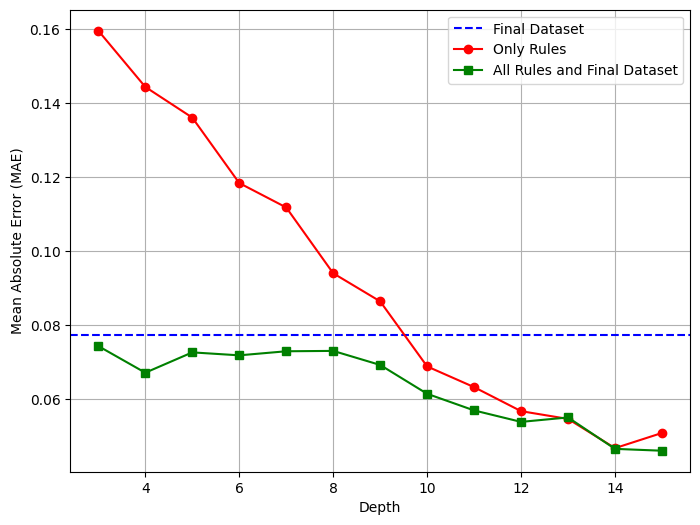

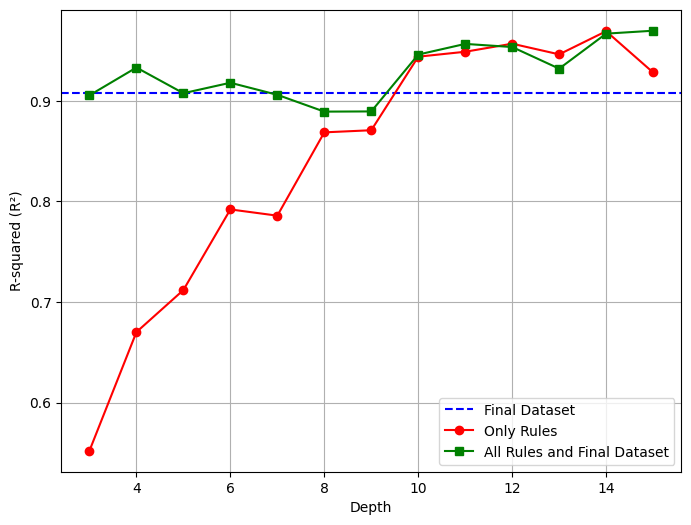

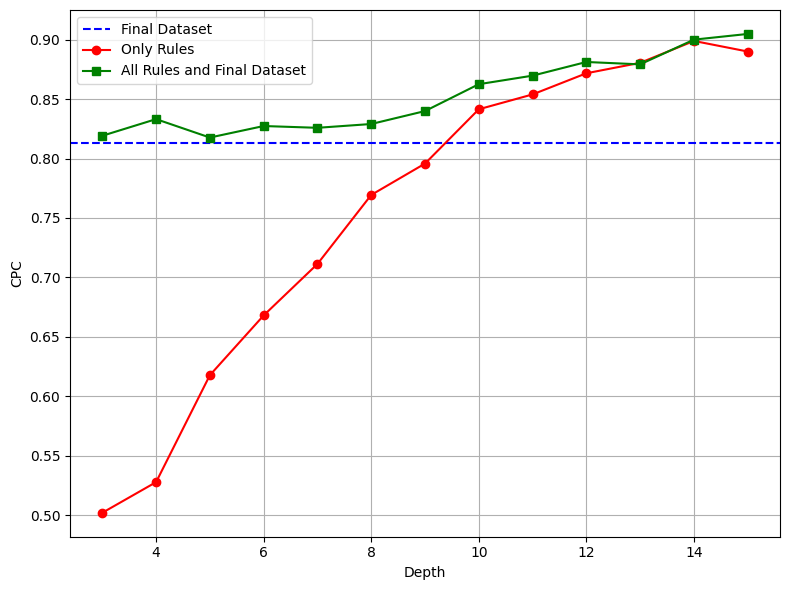

In [4]:
# These are the values obtained by running all the models above
mae_DT3_8=0.1596
mae_DT4_16=0.1444
mae_DT5_32=0.1361
mae_DT6_64=0.1184
mae_DT7_116=0.1118 
mae_DT8_202=0.0940
mae_DT9_324= 0.0864
mae_DT10_505=0.0688
mae_DT11_753=0.0632
mae_DT12_1069=0.0567
mae_DT13_1485=0.0546
mae_DT14_2006=0.0467
mae_DT15_2628=0.0508


r2_DT3_8=0.5522
r2_DT4_16=0.6701
r2_DT5_32=0.7119
r2_DT6_64=0.7920
r2_DT7_116=0.7858
r2_DT8_202=0.8686
r2_DT9_324=0.8707
r2_DT10_505=0.9438
r2_DT11_753=0.9487
r2_DT12_1069=0.9567
r2_DT13_1485=0.9461
r2_DT14_2006=0.9691
r2_DT15_2628=0.9281


cpc_DT3_8=0.5019
cpc_DT4_16=0.5277
cpc_DT5_32=0.6177
cpc_DT6_64=0.6680
cpc_DT7_116=0.7113
cpc_DT8_202=0.7694
cpc_DT9_324=0.7958
cpc_DT10_505=0.8415
cpc_DT11_753=0.8540
cpc_DT12_1069=0.8718
cpc_DT13_1485=0.8806
cpc_DT14_2006=0.8990
cpc_DT15_2628=0.8901


mae_CombinedDT3_8=0.0743
mae_CombinedDT4_16= 0.0671
mae_CombinedDT5_32= 0.0726
mae_CombinedDT6_64=0.0718
mae_CombinedDT7_116= 0.0729
mae_CombinedDT8_202=0.0730
mae_CombinedDT9_324= 0.0692
mae_CombinedDT10_505= 0.0614
mae_CombinedDT11_753=0.0569
mae_CombinedDT12_1069=0.0538 
mae_CombinedDT13_1485=0.0550
mae_CombinedDT14_2006=0.0465 
mae_CombinedDT15_2628=0.0460


r2_CombinedDT3_8=0.9054
r2_CombinedDT4_16=0.9330
r2_CombinedDT5_32=0.9075
r2_CombinedDT6_64=0.9179
r2_CombinedDT7_116=0.9059
r2_CombinedDT8_202=0.8892
r2_CombinedDT9_324=0.8894
r2_CombinedDT10_505=0.9459
r2_CombinedDT11_753=0.9565
r2_CombinedDT12_1069=0.9534
r2_CombinedDT13_1485=0.9319
r2_CombinedDT14_2006=0.9667
r2_CombinedDT15_2628=0.9696


cpc_CombinedDT3_8=0.8192
cpc_CombinedDT4_16=0.8332
cpc_CombinedDT5_32=0.8177
cpc_CombinedDT6_64=0.8274
cpc_CombinedDT7_116=0.8259
cpc_CombinedDT8_202=0.8291
cpc_CombinedDT9_324=0.8400
cpc_CombinedDT10_505=0.8626
cpc_CombinedDT11_753=0.8698
cpc_CombinedDT12_1069=0.8813
cpc_CombinedDT13_1485=0.8793
cpc_CombinedDT14_2006=0.9001
cpc_CombinedDT15_2628=0.9049


mae_Var0CombinedDT3_2 =  0.0680
mae_Var0CombinedDT4_1 = 0.0708
mae_Var0CombinedDT5_2 = 0.0666
mae_Var0CombinedDT6_2 = 0.0670
mae_Var0CombinedDT7_2 = 0.0700
mae_Var0CombinedDT8_2 = 0.0683
mae_Var0CombinedDT9_1 = 0.0634
mae_Var0CombinedDT10_0 = 0.0773
mae_Var0CombinedDT11_0 = 0.0773
mae_Var0CombinedDT12_0 = 0.0773
mae_Var0CombinedDT13_0 = 0.0773
mae_Var0CombinedDT14_0 = 0.0773
mae_Var0CombinedDT15_0 = 0.0773

r2_Var0CombinedDT3_2 =0.9323 
r2_Var0CombinedDT4_1 = 0.9252
r2_Var0CombinedDT5_2 = 0.9467
r2_Var0CombinedDT6_2 = 0.9307
r2_Var0CombinedDT7_2 = 0.9242
r2_Var0CombinedDT8_2 = 0.9387
r2_Var0CombinedDT9_1 = 0.9543
r2_Var0CombinedDT10_0 = 0.9077
r2_Var0CombinedDT11_0 = 0.9077
r2_Var0CombinedDT12_0 = 0.9077
r2_Var0CombinedDT13_0 = 0.9077
r2_Var0CombinedDT14_0 = 0.9077
r2_Var0CombinedDT15_0 = 0.9077

cpc_Var0CombinedDT3_2 = 0.8330
cpc_Var0CombinedDT4_1 = 0.8286
cpc_Var0CombinedDT5_2 = 0.8361
cpc_Var0CombinedDT6_2 = 0.8514
cpc_Var0CombinedDT7_2 = 0.8325
cpc_Var0CombinedDT8_2 = 0.8346
cpc_Var0CombinedDT9_1 = 0.8545
cpc_Var0CombinedDT10_0 = 0.8134
cpc_Var0CombinedDT11_0 = 0.8134
cpc_Var0CombinedDT12_0 = 0.8134
cpc_Var0CombinedDT13_0 = 0.8134
cpc_Var0CombinedDT14_0 = 0.8134
cpc_Var0CombinedDT15_0 = 0.8134


mae_Var1CombinedDT3_6=0.0669
mae_Var1CombinedDT4_7=0.0677 
mae_Var1CombinedDT5_11=0.0704 
mae_Var1CombinedDT6_15=0.0656
mae_Var1CombinedDT7_18=0.0642  
mae_Var1CombinedDT8_20=0.0704
mae_Var1CombinedDT9_20=0.0726 
mae_Var1CombinedDT10_23=0.0698 
mae_Var1CombinedDT11_20=0.0708
mae_Var1CombinedDT12_18=0.0715 
mae_Var1CombinedDT13_14=0.0719
mae_Var1CombinedDT14_8= 0.0733
mae_Var1CombinedDT15_5=0.0694
 


r2_Var1CombinedDT3_6=0.9352
r2_Var1CombinedDT4_7= 0.9327
r2_Var1CombinedDT5_11=0.9179
r2_Var1CombinedDT6_15=0.9343
r2_Var1CombinedDT7_18=0.9373
r2_Var1CombinedDT8_20=0.9169
r2_Var1CombinedDT9_20=0.9076
r2_Var1CombinedDT10_23=0.9318
r2_Var1CombinedDT11_20=0.9333
r2_Var1CombinedDT12_18=0.9266
r2_Var1CombinedDT13_14=0.9221
r2_Var1CombinedDT14_8=0.9234
r2_Var1CombinedDT15_5=0.9337


cpc_Var1CombinedDT3_6=0.8396
cpc_Var1CombinedDT4_7= 0.8326
cpc_Var1CombinedDT5_11=0.8180
cpc_Var1CombinedDT6_15=0.8416
cpc_Var1CombinedDT7_18=0.8478
cpc_Var1CombinedDT8_20=0.8345
cpc_Var1CombinedDT9_20=0.8259
cpc_Var1CombinedDT10_23=0.8305
cpc_Var1CombinedDT11_20=0.8231
cpc_Var1CombinedDT12_18=0.8195 
cpc_Var1CombinedDT13_14=0.8179
cpc_Var1CombinedDT14_8=0.8192
cpc_Var1CombinedDT15_5=0.8332

mae_Var2CombinedDT3_8=0.0672
mae_Var2CombinedDT4_14= 0.0675
mae_Var2CombinedDT5_24= 0.0736
mae_Var2CombinedDT6_32=0.0627
mae_Var2CombinedDT7_46= 0.0707 
mae_Var2CombinedDT8_60=0.0645
mae_Var2CombinedDT9_83= 0.0626
mae_Var2CombinedDT10_103= 0.0628
mae_Var2CombinedDT11_128=0.0690
mae_Var2CombinedDT12_157= 0.0691
mae_Var2CombinedDT13_164=0.0724
mae_Var2CombinedDT14_174= 0.0711
mae_Var2CombinedDT15_171=0.0760
 


r2_Var2CombinedDT3_8=0.9320
r2_Var2CombinedDT4_14=0.9374
r2_Var2CombinedDT5_24=0.9151
r2_Var2CombinedDT6_32=0.9356
r2_Var2CombinedDT7_46=0.9141
r2_Var2CombinedDT8_60=0.9282
r2_Var2CombinedDT9_83=0.9502
r2_Var2CombinedDT10_103=0.9415
r2_Var2CombinedDT11_128=0.9227
r2_Var2CombinedDT12_157=0.9162
r2_Var2CombinedDT13_164=0.9218
r2_Var2CombinedDT14_174=0.9277
r2_Var2CombinedDT15_171=0.9085


cpc_Var2CombinedDT3_8=0.8347
cpc_Var2CombinedDT4_14=0.8380
cpc_Var2CombinedDT5_24=0.8028
cpc_Var2CombinedDT6_32=0.8518
cpc_Var2CombinedDT7_46=0.8383
cpc_Var2CombinedDT8_60=0.8455
cpc_Var2CombinedDT9_83=0.8562
cpc_Var2CombinedDT10_103=0.8562
cpc_Var2CombinedDT11_128=0.8267
cpc_Var2CombinedDT12_157= 0.8230
cpc_Var2CombinedDT13_164=0.8148
cpc_Var2CombinedDT14_174=0.8250
cpc_Var2CombinedDT15_171=0.7941

mae_Var3CombinedDT3_8= 0.0733
mae_Var3CombinedDT4_16= 0.0689
mae_Var3CombinedDT5_32= 0.0731
mae_Var3CombinedDT6_58=0.0733
mae_Var3CombinedDT7_101=0.0751  
mae_Var3CombinedDT8_163=0.0695
mae_Var3CombinedDT9_251= 0.0658
mae_Var3CombinedDT10_374= 0.0615
mae_Var3CombinedDT11_531=0.0608
mae_Var3CombinedDT12_735= 0.0609
mae_Var3CombinedDT13_992=0.0643
mae_Var3CombinedDT14_1278= 0.0586
mae_Var3CombinedDT15_1595=0.0589
 


r2_Var3CombinedDT3_8=0.9137
r2_Var3CombinedDT4_16=0.9377
r2_Var3CombinedDT5_32=0.9076
r2_Var3CombinedDT6_58=0.9100
r2_Var3CombinedDT7_101=0.8731
r2_Var3CombinedDT8_163=0.9182
r2_Var3CombinedDT9_251=0.9315
r2_Var3CombinedDT10_374=0.9489
r2_Var3CombinedDT11_531=0.9406
r2_Var3CombinedDT12_735=0.9372
r2_Var3CombinedDT13_992=0.9095
r2_Var3CombinedDT14_1278=0.9219
r2_Var3CombinedDT15_1595=0.9240


cpc_Var3CombinedDT3_8=0.8203
cpc_Var3CombinedDT4_16=0.8403
cpc_Var3CombinedDT5_32=0.8282
cpc_Var3CombinedDT6_58=0.8143
cpc_Var3CombinedDT7_101=0.8158
cpc_Var3CombinedDT8_163=0.8276
cpc_Var3CombinedDT9_251=0.8459
cpc_Var3CombinedDT10_374=0.8537
cpc_Var3CombinedDT11_531=0.8574
cpc_Var3CombinedDT12_735= 0.8553
cpc_Var3CombinedDT13_992=0.8502
cpc_Var3CombinedDT14_1278=0.8662
cpc_Var3CombinedDT15_1595=0.8606






# Data
depth = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,15]
rules = [8, 16, 32, 64, 116, 202, 324, 505, 753, 1069, 1485, 2006, 2628]
rules_var0 = [2,1, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0]
rules_var1 = [6, 7, 11, 15, 18, 20, 20, 23, 20, 18, 14, 8, 5]
rules_var2 = [8, 14, 24, 32, 46, 60, 83, 103, 128, 157, 164, 174, 171]
rules_var3 = [8, 16, 32, 58, 101, 163, 251, 374, 531, 735, 992, 1278, 1595]
mae_NN = [mae_DT3_8, mae_DT4_16, mae_DT5_32, mae_DT6_64, mae_DT7_116, mae_DT8_202, mae_DT9_324, mae_DT10_505, mae_DT11_753, mae_DT12_1069, mae_DT13_1485, mae_DT14_2006, mae_DT15_2628]
r2_NN = [r2_DT3_8, r2_DT4_16, r2_DT5_32, r2_DT6_64, r2_DT7_116, r2_DT8_202, r2_DT9_324, r2_DT10_505, r2_DT11_753, r2_DT12_1069, r2_DT13_1485, r2_DT14_2006, r2_DT15_2628]
cpc_NN = [cpc_DT3_8, cpc_DT4_16, cpc_DT5_32, cpc_DT6_64, cpc_DT7_116, cpc_DT8_202, cpc_DT9_324, cpc_DT10_505, cpc_DT11_753, cpc_DT12_1069, cpc_DT13_1485, cpc_DT14_2006, cpc_DT15_2628]
mae_Combined = [mae_CombinedDT3_8, mae_CombinedDT4_16, mae_CombinedDT5_32, mae_CombinedDT6_64, mae_CombinedDT7_116, mae_CombinedDT8_202, mae_CombinedDT9_324, mae_CombinedDT10_505, mae_CombinedDT11_753, mae_CombinedDT12_1069, mae_CombinedDT13_1485, mae_CombinedDT14_2006, mae_CombinedDT15_2628]
r2_Combined = [r2_CombinedDT3_8, r2_CombinedDT4_16, r2_CombinedDT5_32, r2_CombinedDT6_64, r2_CombinedDT7_116, r2_CombinedDT8_202, r2_CombinedDT9_324, r2_CombinedDT10_505, r2_CombinedDT11_753, r2_CombinedDT12_1069, r2_CombinedDT13_1485, r2_CombinedDT14_2006, r2_CombinedDT15_2628]
cpc_Combined = [cpc_CombinedDT3_8, cpc_CombinedDT4_16, cpc_CombinedDT5_32, cpc_CombinedDT6_64, cpc_CombinedDT7_116, cpc_CombinedDT8_202, cpc_CombinedDT9_324, cpc_CombinedDT10_505, cpc_CombinedDT11_753, cpc_CombinedDT12_1069, cpc_CombinedDT13_1485, cpc_CombinedDT14_2006, cpc_CombinedDT15_2628]



mae_Var0Combined = [mae_Var0CombinedDT3_2, mae_Var0CombinedDT4_1, mae_Var0CombinedDT5_2, mae_Var0CombinedDT6_2, mae_Var0CombinedDT7_2, mae_Var0CombinedDT8_2, mae_Var0CombinedDT9_1, mae_Var0CombinedDT10_0, mae_Var0CombinedDT11_0, mae_Var0CombinedDT12_0, mae_Var0CombinedDT13_0, mae_Var0CombinedDT14_0, mae_Var0CombinedDT15_0]
r2_Var0Combined = [r2_Var0CombinedDT3_2, r2_Var0CombinedDT4_1, r2_Var0CombinedDT5_2, r2_Var0CombinedDT6_2, r2_Var0CombinedDT7_2, r2_Var0CombinedDT8_2, r2_Var0CombinedDT9_1, r2_Var0CombinedDT10_0, r2_Var0CombinedDT11_0, r2_Var0CombinedDT12_0, r2_Var0CombinedDT13_0, r2_Var0CombinedDT14_0, r2_Var0CombinedDT15_0]
cpc_Var0Combined = [cpc_Var0CombinedDT3_2, cpc_Var0CombinedDT4_1, cpc_Var0CombinedDT5_2, cpc_Var0CombinedDT6_2, cpc_Var0CombinedDT7_2, cpc_Var0CombinedDT8_2, cpc_Var0CombinedDT9_1, cpc_Var0CombinedDT10_0, cpc_Var0CombinedDT11_0, cpc_Var0CombinedDT12_0, cpc_Var0CombinedDT13_0, cpc_Var0CombinedDT14_0, cpc_Var0CombinedDT15_0]


mae_Var1Combined = [mae_Var1CombinedDT3_6, mae_Var1CombinedDT4_7, mae_Var1CombinedDT5_11, mae_Var1CombinedDT6_15, mae_Var1CombinedDT7_18, mae_Var1CombinedDT8_20, mae_Var1CombinedDT9_20, mae_Var1CombinedDT10_23, mae_Var1CombinedDT11_20, mae_Var1CombinedDT12_18, mae_Var1CombinedDT13_14, mae_Var1CombinedDT14_8, mae_Var1CombinedDT15_5]
r2_Var1Combined = [r2_Var1CombinedDT3_6, r2_Var1CombinedDT4_7, r2_Var1CombinedDT5_11, r2_Var1CombinedDT6_15, r2_Var1CombinedDT7_18, r2_Var1CombinedDT8_20, r2_Var1CombinedDT9_20, r2_Var1CombinedDT10_23, r2_Var1CombinedDT11_20, r2_Var1CombinedDT12_18, r2_Var1CombinedDT13_14, r2_Var1CombinedDT14_8, r2_Var1CombinedDT15_5]
cpc_Var1Combined = [cpc_Var1CombinedDT3_6, cpc_Var1CombinedDT4_7, cpc_Var1CombinedDT5_11, cpc_Var1CombinedDT6_15, cpc_Var1CombinedDT7_18, cpc_Var1CombinedDT8_20, cpc_Var1CombinedDT9_20, cpc_Var1CombinedDT10_23, cpc_Var1CombinedDT11_20, cpc_Var1CombinedDT12_18, cpc_Var1CombinedDT13_14, cpc_Var1CombinedDT14_8, cpc_Var1CombinedDT15_5]


mae_Var2Combined = [mae_Var2CombinedDT3_8, mae_Var2CombinedDT4_14, mae_Var2CombinedDT5_24, mae_Var2CombinedDT6_32, mae_Var2CombinedDT7_46, mae_Var2CombinedDT8_60, mae_Var2CombinedDT9_83, mae_Var2CombinedDT10_103, mae_Var2CombinedDT11_128, mae_Var2CombinedDT12_157, mae_Var2CombinedDT13_164, mae_Var2CombinedDT14_174, mae_Var2CombinedDT15_171]
r2_Var2Combined = [r2_Var2CombinedDT3_8, r2_Var2CombinedDT4_14, r2_Var2CombinedDT5_24, r2_Var2CombinedDT6_32, r2_Var2CombinedDT7_46, r2_Var2CombinedDT8_60, r2_Var2CombinedDT9_83, r2_Var2CombinedDT10_103, r2_Var2CombinedDT11_128, r2_Var2CombinedDT12_157, r2_Var2CombinedDT13_164, r2_Var2CombinedDT14_174, r2_Var2CombinedDT15_171]
cpc_Var2Combined = [cpc_Var2CombinedDT3_8, cpc_Var2CombinedDT4_14, cpc_Var2CombinedDT5_24, cpc_Var2CombinedDT6_32, cpc_Var2CombinedDT7_46, cpc_Var2CombinedDT8_60, cpc_Var2CombinedDT9_83, cpc_Var2CombinedDT10_103, cpc_Var2CombinedDT11_128, cpc_Var2CombinedDT12_157, cpc_Var2CombinedDT13_164, cpc_Var2CombinedDT14_174, cpc_Var2CombinedDT15_171]

mae_Var3Combined = [mae_Var3CombinedDT3_8, mae_Var3CombinedDT4_16, mae_Var3CombinedDT5_32, mae_Var3CombinedDT6_58, mae_Var3CombinedDT7_101, mae_Var3CombinedDT8_163, mae_Var3CombinedDT9_251, mae_Var3CombinedDT10_374, mae_Var3CombinedDT11_531, mae_Var3CombinedDT12_735, mae_Var3CombinedDT13_992, mae_Var3CombinedDT14_1278, mae_Var3CombinedDT15_1595]
r2_Var3Combined = [r2_Var3CombinedDT3_8, r2_Var3CombinedDT4_16, r2_Var3CombinedDT5_32, r2_Var3CombinedDT6_58, r2_Var3CombinedDT7_101, r2_Var3CombinedDT8_163, r2_Var3CombinedDT9_251, r2_Var3CombinedDT10_374, r2_Var3CombinedDT11_531, r2_Var3CombinedDT12_735, r2_Var3CombinedDT13_992, r2_Var3CombinedDT14_1278, r2_Var3CombinedDT15_1595]
cpc_Var3Combined = [cpc_Var3CombinedDT3_8, cpc_Var3CombinedDT4_16, cpc_Var3CombinedDT5_32, cpc_Var3CombinedDT6_58, cpc_Var3CombinedDT7_101, cpc_Var3CombinedDT8_163, cpc_Var3CombinedDT9_251, cpc_Var3CombinedDT10_374, cpc_Var3CombinedDT11_531, cpc_Var3CombinedDT12_735, cpc_Var3CombinedDT13_992, cpc_Var3CombinedDT14_1278, cpc_Var3CombinedDT15_1595]



# MAE
plt.figure(figsize=(8, 6))
simple_nn_mae = 0.0773
plt.axhline(y=simple_nn_mae, color='blue', linestyle='--', label='Final Dataset')
plt.plot(depth, mae_NN, marker='o', label='Only Rules', color='red')
plt.plot(depth, mae_Combined, marker='s', label='All Rules and Final Dataset', color='green')
# plt.plot(depth, mae_Var0Combined, marker='x', label='Rules (0.1 Variance) and Original Dataset', color='#F08080')
# plt.plot(depth, mae_Var1Combined, marker='x', label='Rules (0.01 Variance) and Original Dataset', color='cyan')
# plt.plot(depth, mae_Var2Combined, marker='x', label='Rules (0.001 Variance) and Original Dataset', color='orange')
# plt.plot(depth, mae_Var3Combined, marker='x', label='Rules (0.0001 Variance) and Original Dataset', color='magenta')
# Add a horizontal line for the simple NN model's MAE
# plt.title("NN Performance Metrics by Decision Tree Depth")
plt.xlabel("Depth")
plt.ylabel("Mean Absolute Error (MAE)")
plt.grid(True)
plt.legend()

# R²
plt.figure(figsize=(8, 6))
simple_nn_r2 = 0.9077
plt.axhline(y=simple_nn_r2, color='blue', linestyle='--', label='Final Dataset')
plt.plot(depth, r2_NN, marker='o', label='Only Rules', color='red')
plt.plot(depth, r2_Combined, marker='s', label='All Rules and Final Dataset', color='green')
# plt.plot(depth, r2_Var0Combined, marker='x', label='Rules (0.1 Variance) and Original Dataset', color='#F08080')
# plt.plot(depth, r2_Var1Combined, marker='x', label='Rules (0.01 Variance) and Original Dataset', color='cyan')
# plt.plot(depth, r2_Var2Combined, marker='x', label='Rules (0.001 Variance) and Original Dataset', color='orange')
# plt.plot(depth, r2_Var3Combined, marker='x', label='Rules (0.0001 Variance) and Original Dataset', color='magenta')
# Add a horizontal line for the simple NN model's MAE
plt.xlabel("Depth")
plt.ylabel("R-squared (R²)")
plt.grid(True)
plt.legend()

# CPC
plt.figure(figsize=(8, 6))
simple_nn_cpc = 0.8134
plt.axhline(y=simple_nn_cpc, color='blue', linestyle='--', label='Final Dataset')
plt.plot(depth, cpc_NN, marker='o', label='Only Rules', color='red')
plt.plot(depth, cpc_Combined, marker='s', label='All Rules and Final Dataset', color='green')
# plt.plot(depth, cpc_Var0Combined, marker='x', label='Rules (0.1 Variance) and Original Dataset', color='#F08080')
# plt.plot(depth, cpc_Var1Combined, marker='x', label='Rules (0.01 Variance) and Original Dataset', color='cyan')
# plt.plot(depth, cpc_Var2Combined, marker='x', label='Rules (0.001 Variance) and Original Dataset', color='orange') # Cyan Black Magenta
# plt.plot(depth, cpc_Var3Combined, marker='x', label='Rules (0.0001 Variance) and Original Dataset', color='magenta')
# Add a horizontal line for the simple NN model's MAE
plt.xlabel("Depth")
plt.ylabel("CPC")
plt.grid(True)
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()


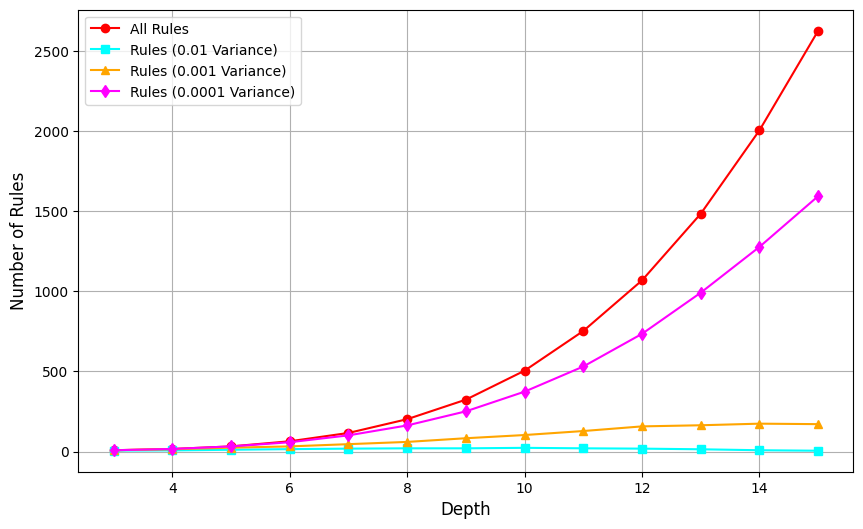

In [7]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(depth, rules, marker='o', label='All Rules', color='red')
# plt.plot(depth, rules_var0, marker='x', label='Rules (0.1 Variance)', color='#F08080')
plt.plot(depth, rules_var1, marker='s', label='Rules (0.01 Variance)', color='cyan')
plt.plot(depth, rules_var2, marker='^', label='Rules (0.001 Variance)', color='orange')
plt.plot(depth, rules_var3, marker='d', label='Rules (0.0001 Variance)', color='magenta')

# Labels and Title
# plt.title("Rules by Decision Tree Depth", fontsize=14)
plt.xlabel("Depth", fontsize=12)
plt.ylabel("Number of Rules", fontsize=12)
plt.grid(True)
plt.legend(fontsize=10)

# Show plot
plt.show()

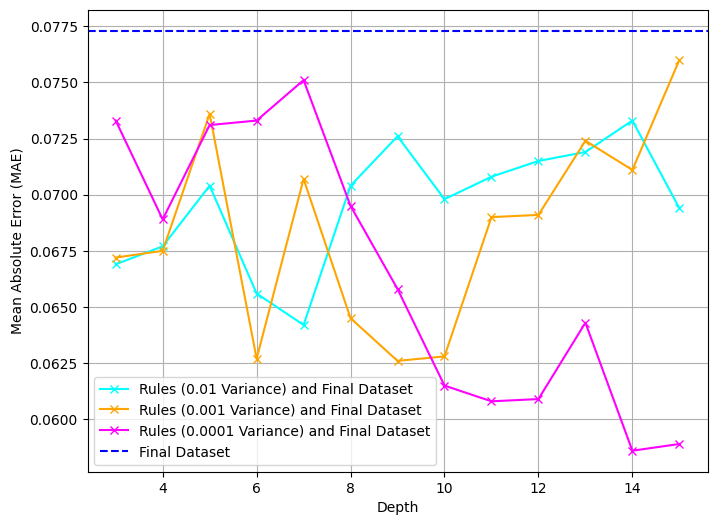

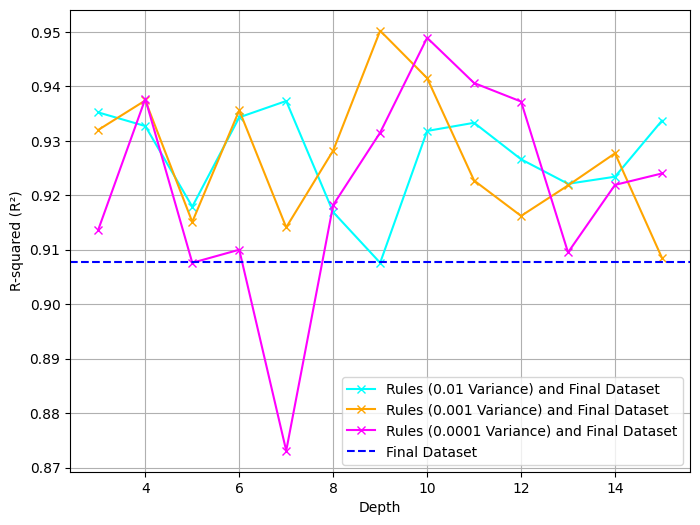

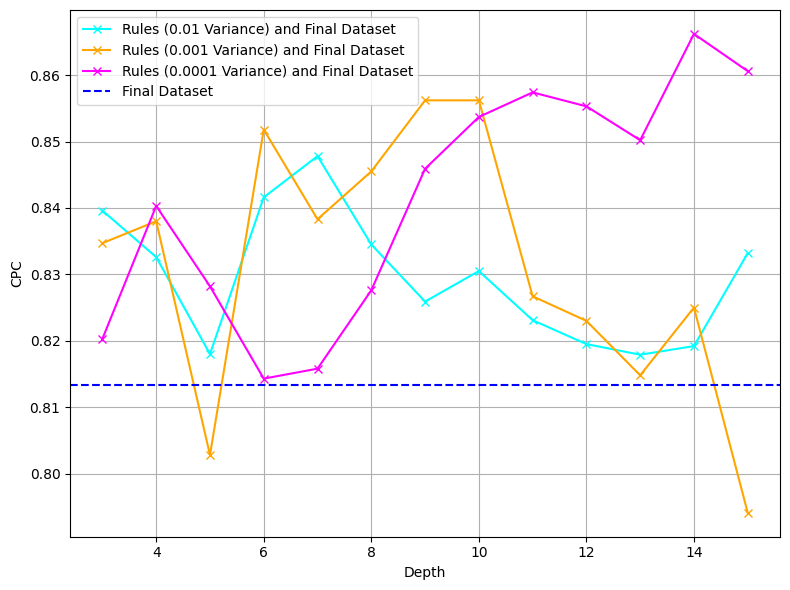

In [8]:
# MAE
plt.figure(figsize=(8, 6))
# plt.plot(depth, mae_NN, marker='o', label='Only Rules', color='red')
# plt.plot(depth, mae_Combined, marker='s', label='All Rules and Original Dataset', color='green')
# plt.plot(depth, mae_Var0Combined, marker='x', label='Rules (0.1 Variance) and Original Dataset', color='#F08080')
plt.plot(depth, mae_Var1Combined, marker='x', label='Rules (0.01 Variance) and Final Dataset', color='cyan')
plt.plot(depth, mae_Var2Combined, marker='x', label='Rules (0.001 Variance) and Final Dataset', color='orange')
plt.plot(depth, mae_Var3Combined, marker='x', label='Rules (0.0001 Variance) and Final Dataset', color='magenta')
# Add a horizontal line for the simple NN model's MAE
simple_nn_mae = 0.0773
plt.axhline(y=simple_nn_mae, color='blue', linestyle='--', label='Final Dataset')
# plt.title("NN Performance Metrics by Decision Tree Depth")
plt.xlabel("Depth")
plt.ylabel("Mean Absolute Error (MAE)")
plt.grid(True)
plt.legend()

# R²
plt.figure(figsize=(8, 6))
# plt.plot(depth, r2_NN, marker='o', label='Only Rules', color='red')
# plt.plot(depth, r2_Combined, marker='s', label='All Rules and Original Dataset', color='green')
# plt.plot(depth, r2_Var0Combined, marker='x', label='Rules (0.1 Variance) and Original Dataset', color='#F08080')
plt.plot(depth, r2_Var1Combined, marker='x', label='Rules (0.01 Variance) and Final Dataset', color='cyan')
plt.plot(depth, r2_Var2Combined, marker='x', label='Rules (0.001 Variance) and Final Dataset', color='orange')
plt.plot(depth, r2_Var3Combined, marker='x', label='Rules (0.0001 Variance) and Final Dataset', color='magenta')
# Add a horizontal line for the simple NN model's MAE
simple_nn_r2 = 0.9077
plt.axhline(y=simple_nn_r2, color='blue', linestyle='--', label='Final Dataset')
plt.xlabel("Depth")
plt.ylabel("R-squared (R²)")
plt.grid(True)
plt.legend()

# CPC
plt.figure(figsize=(8, 6))
# plt.plot(depth, cpc_NN, marker='o', label='Only Rules', color='red')
# plt.plot(depth, cpc_Combined, marker='s', label='All Rules and Original Dataset', color='green')
# plt.plot(depth, cpc_Var0Combined, marker='x', label='Rules (0.1 Variance) and Original Dataset', color='#F08080')
plt.plot(depth, cpc_Var1Combined, marker='x', label='Rules (0.01 Variance) and Final Dataset', color='cyan')
plt.plot(depth, cpc_Var2Combined, marker='x', label='Rules (0.001 Variance) and Final Dataset', color='orange') # Cyan Black Magenta
plt.plot(depth, cpc_Var3Combined, marker='x', label='Rules (0.0001 Variance) and Final Dataset', color='magenta')
# Add a horizontal line for the simple NN model's MAE
simple_nn_cpc = 0.8134
plt.axhline(y=simple_nn_cpc, color='blue', linestyle='--', label='Final Dataset')
plt.xlabel("Depth")
plt.ylabel("CPC")
plt.grid(True)
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()


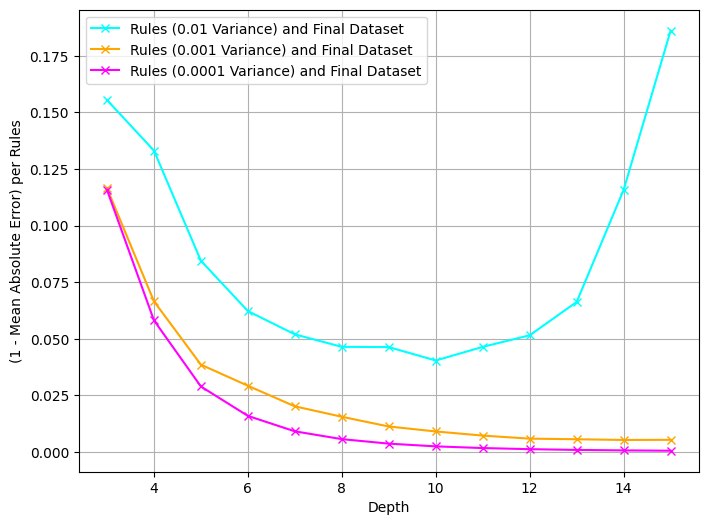

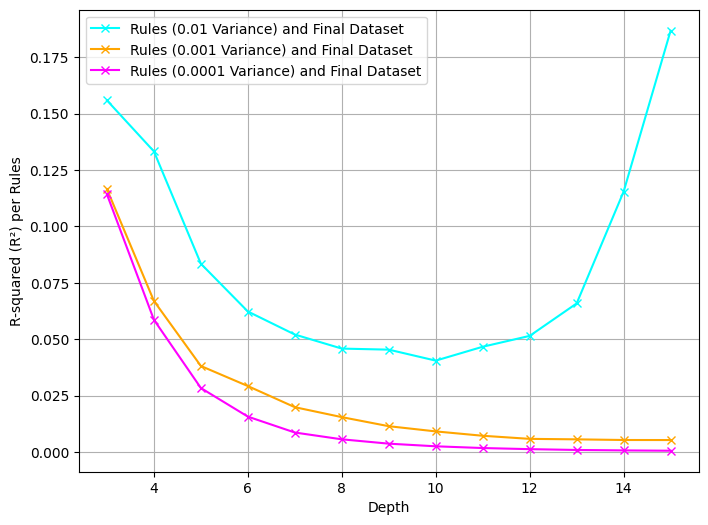

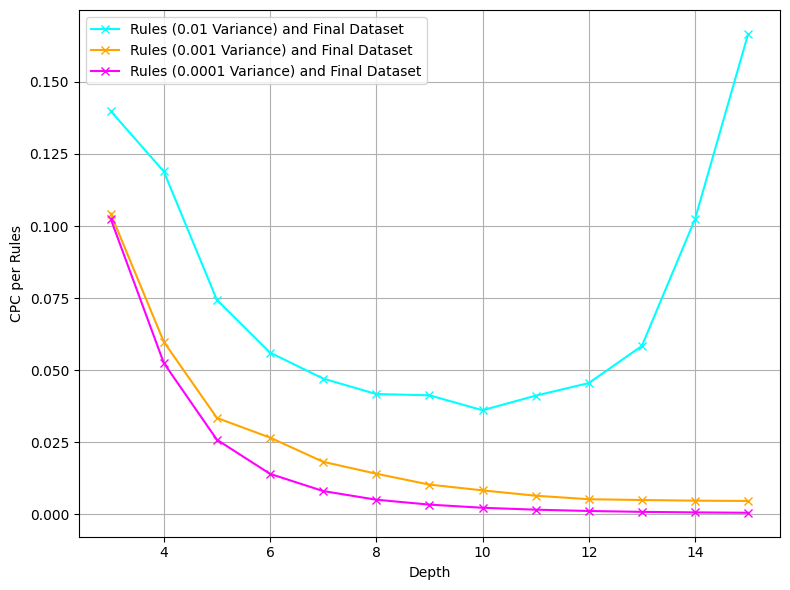

In [9]:
# MAE
plt.figure(figsize=(8, 6))
# plt.plot(depth, [a / b for a, b in zip([1 - x for x in mae_NN], rules)] , marker='o', linestyle='--', label='Only Rules', color='red')
# plt.plot(depth, [a / b for a, b in zip([1 - x for x in mae_Combined], rules)], marker='s', label='All Rules and Original Dataset', color='green')
# plt.plot(depth, [a / b for a, b in zip([1 - x for x in mae_Var0Combined], rules_var0)], marker='x', label='Rules (0.1 Variance) and Original Dataset', color='yellow')
plt.plot(depth, [a / b for a, b in zip([1 - x for x in mae_Var1Combined], rules_var1)], marker='x', label='Rules (0.01 Variance) and Final Dataset', color='cyan')
plt.plot(depth, [a / b for a, b in zip([1 - x for x in mae_Var2Combined], rules_var2)], marker='x', label='Rules (0.001 Variance) and Final Dataset', color='orange')
plt.plot(depth, [a / b for a, b in zip([1 - x for x in mae_Var3Combined], rules_var3)], marker='x', label='Rules (0.0001 Variance) and Final Dataset', color='magenta')
# plt.title("NN Performance Metrics by Decision Tree Depth")
plt.xlabel("Depth")
plt.ylabel("(1 - Mean Absolute Error) per Rules")
plt.grid(True)
plt.legend()

# R²
plt.figure(figsize=(8, 6))
# plt.plot(depth, [a / b for a, b in zip(r2_NN, rules)], marker='o', linestyle='--', label='Only Rules', color='red')
# plt.plot(depth,[a / b for a, b in zip(r2_Combined, rules)] , marker='s', label='All Rules and Original Dataset', color='green')
# plt.plot(depth, [a / b for a, b in zip(r2_Var0Combined, rules_var0)], marker='x', label='Rules (0.1 Variance) and Original Dataset', color='yellow')
plt.plot(depth, [a / b for a, b in zip(r2_Var1Combined, rules_var1)], marker='x', label='Rules (0.01 Variance) and Final Dataset', color='cyan')
plt.plot(depth, [a / b for a, b in zip(r2_Var2Combined, rules_var2)], marker='x', label='Rules (0.001 Variance) and Final Dataset', color='orange')
plt.plot(depth, [a / b for a, b in zip(r2_Var3Combined, rules_var3)], marker='x', label='Rules (0.0001 Variance) and Final Dataset', color='magenta')
plt.xlabel("Depth")
plt.ylabel("R-squared (R²) per Rules")
plt.grid(True)
plt.legend()

# CPC
plt.figure(figsize=(8, 6))
# plt.plot(depth, [a / b for a, b in zip(cpc_NN, rules)], marker='o', linestyle='--', label='Only Rules', color='red')
# plt.plot(depth, [a / b for a, b in zip(cpc_Combined, rules)], marker='s', label='All Rules and Original Dataset', color='green')
# plt.plot(depth, [a / b for a, b in zip(cpc_Var0Combined, rules_var0)], marker='x', label='Rules (0.1 Variance) and Original Dataset', color='yellow')
plt.plot(depth, [a / b for a, b in zip(cpc_Var1Combined, rules_var1)], marker='x', label='Rules (0.01 Variance) and Final Dataset', color='cyan')
plt.plot(depth, [a / b for a, b in zip(cpc_Var2Combined, rules_var2)], marker='x', label='Rules (0.001 Variance) and Final Dataset', color='orange')
plt.plot(depth, [a / b for a, b in zip(cpc_Var3Combined, rules_var3)], marker='x', label='Rules (0.0001 Variance) and Final Dataset', color='magenta')
plt.xlabel("Depth")
plt.ylabel("CPC per Rules")
plt.grid(True)
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()